# EDA for Tel Aviv for Micro Mobility

* Check number of accidents per quarter
    * Compare to number of total accidents excluding micro mobility
    * Ratio of number accident
* Bicycle Path Length in relation to Quarter area.
    * Pearson Correlation between length of BP and number of accidents for each quarter
* Graph of number of accidents per quarter and total length of bicycle path in regards to time 
    * Normalize by population in Tel Aviv
    * Scatter plot x is length of BP, y number of accidents.
        * One general scatter plot
        * Each quarter a specific plot
    * Scatter plot but with accidents that are severe
* Compare BP length to streets length


Things for next time 04/09/2024
* add sources of data
* check accuracy of accidents, עיגון column "location accuracy"
    * % in each Quarter 
* per quarter accidents for total share of bp in relation to streets length
* get data of shops and gardens

Create specific graphs:
* line graph, instead of bp lane length the share over the years
    * severe accidents
    * general for all the city, not by quarter
    * filter for accident accuracy
* Add units in graphs

15/9/2024 current next step:

* Fix street names in **Checking how many streets pass through multiple quarters.**

        Currently I have some streets like שאול המלך that don't align with שד שאול המלך
        Also streets like '1184', where I'm not sure if it exists in accidents or not.

23/9/2024

I fixed some streets, hopefully it will suffice.


In [82]:
import matplotlib.pyplot as plt
from shapely.geometry import Point
import geopandas as gpd
import pandas as pd
import numpy as np
from IPython.display import Image, display

### Loading Quarters Data

In [83]:
ta_q = gpd.read_file("./csv_tables/TA_Quaters_UTM/Quarters.shp")
ta_q.oidrova = pd.to_numeric(ta_q.oidrova, downcast='integer')
ta_q.krova = pd.to_numeric(ta_q.krova, downcast='integer')
display(ta_q.crs)
ta_q

<Projected CRS: EPSG:32636>
Name: WGS 84 / UTM zone 36N
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: Between 30°E and 36°E, northern hemisphere between equator and 84°N, onshore and offshore. Belarus. Cyprus. Egypt. Ethiopia. Finland. Israel. Jordan. Kenya. Lebanon. Moldova. Norway. Russian Federation. Saudi Arabia. Sudan. Syria. Türkiye (Turkey). Uganda. Ukraine.
- bounds: (30.0, 0.0, 36.0, 84.0)
Coordinate Operation:
- name: UTM zone 36N
- method: Transverse Mercator
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

,oidrova,krova,dateimport,ShapeArea,geometry
0,1,1,01/12/2015 02:28:14,1.301654e+07,"POLYGON ((670795.655 3555762.452, 670797.577 3..."
1,2,2,01/12/2015 02:28:14,8.013404e+06,"POLYGON ((672021.029 3553364.492, 672014.690 3..."
2,3,3,01/12/2015 02:28:14,3.380430e+06,"POLYGON ((668311.070 3552547.701, 668311.229 3..."
3,4,4,01/12/2015 02:28:14,4.510255e+06,"POLYGON ((670771.828 3552544.564, 670771.584 3..."
4,5,6,01/12/2015 02:28:14,2.089044e+06,"POLYGON ((668160.048 3550196.192, 668162.425 3..."
5,6,9,01/12/2015 02:28:14,7.879856e+06,"POLYGON ((668811.121 3546980.368, 668808.698 3..."
6,7,5,01/12/2015 02:28:14,3.024297e+06,"POLYGON ((666698.783 3550619.396, 666701.339 3..."
7,8,8,01/12/2015 02:28:14,3.420996e+06,"POLYGON ((667954.133 3548820.374, 667956.725 3..."
8,9,7,01/12/2015 02:28:14,6.343551e+06,"POLYGON ((665854.540 3548193.053, 665868.137 3..."


#### Plotting Quarters

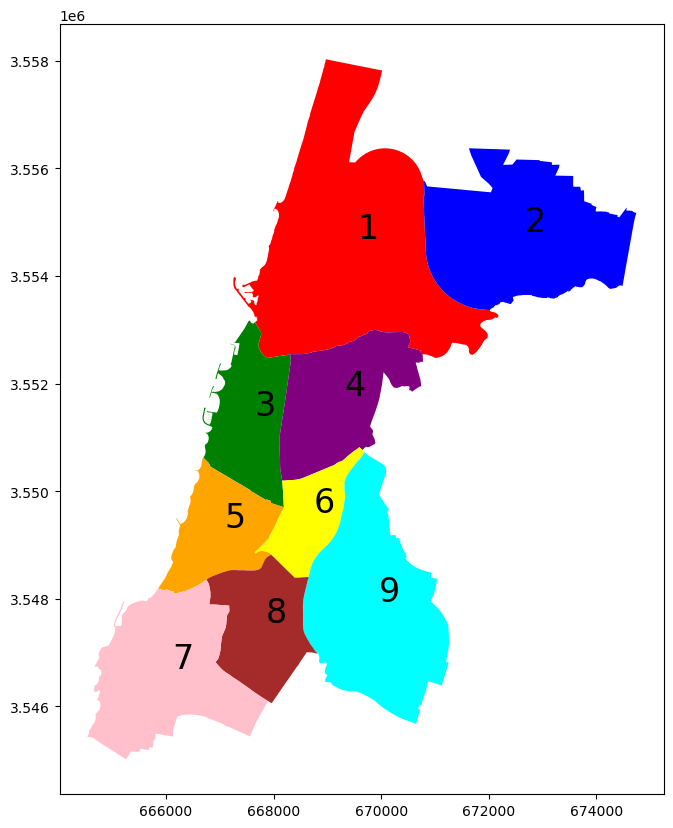

In [84]:
ta_q['index'] = ta_q.index

# Define a list of colors
color_map = {
    1: 'red', 2: 'blue', 3: 'green', 4: 'purple',
    5: 'orange', 6: 'yellow', 7: 'pink', 8: 'brown', 9: 'cyan'
}

# Basic plotting
fig, ax = plt.subplots(figsize=(10, 10))

# Plot each shape with a different color from the list
for idx, row in ta_q.iterrows():
    color = color_map[row['krova']]  # Cycle through the colors list
    gpd.GeoSeries([row['geometry']]).plot(ax=ax, color=color)

    # Get the centroid of the polygon to place the text
    centroid = row['geometry'].centroid
    ax.annotate(text=row['krova'], xy=(centroid.x, centroid.y), 
                xytext=(3, 3), textcoords="offset points",
                fontsize=24, color='black')

plt.show()

### Loading TA Accidents and TA Micro Mobility Accidents

In [85]:
# Exclude micro mobility
BICYCLE = 15
SCOOTER = 21
E_BICYCLE = 23
micro_m = [SCOOTER, E_BICYCLE, BICYCLE]


In [86]:
# Load original accident data
i_m_h_ta_gdf = gpd.read_parquet('./csv_tables/i_m_h_ta_gdf.parquet')

In [87]:
# Accidents that are not MM
i_m_h_ta_no_mm_gdf = i_m_h_ta_gdf[~(i_m_h_ta_gdf.involve_vehicle_type.isin(micro_m))].copy()

In [88]:
# Accidents that are just MM
i_m_h_ta_mm_gdf =  gpd.read_parquet('./csv_tables/i_m_h_ta_mm_gdf.parquet')
display(i_m_h_ta_mm_gdf.crs)
i_m_h_ta_mm_gdf.head(5)

<Projected CRS: EPSG:32636>
Name: WGS 84 / UTM zone 36N
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: Between 30°E and 36°E, northern hemisphere between equator and 84°N, onshore and offshore. Belarus. Cyprus. Egypt. Ethiopia. Finland. Israel. Jordan. Kenya. Lebanon. Moldova. Norway. Russian Federation. Saudi Arabia. Sudan. Syria. Türkiye (Turkey). Uganda. Ukraine.
- bounds: (30.0, 0.0, 36.0, 84.0)
Coordinate Operation:
- name: UTM zone 36N
- method: Transverse Mercator
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

,accident_id,provider_and_id,provider_code,file_type_police,involved_type,involved_type_hebrew,license_acquiring_date,age_group,age_group_hebrew,sex,...,vehicle_attribution,vehicle_attribution_hebrew,seats,total_weight,total_weight_hebrew,vehicle_damage,vehicle_damage_hebrew,urban_intersection,accident_date,geometry
41,2013001368,32013001368,3,3,2,נהג נפגע,0,6,25-29,1,...,1.0,ישראלי,99.0,0.0,לא ידוע,4.0,אין נזק,NaN,2013-07-27 01:00:00,POINT (667544.749 3549959.961)
50,2013001742,32013001742,3,3,2,נהג נפגע,0,7,30-34,2,...,1.0,ישראלי,99.0,0.0,לא ידוע,4.0,אין נזק,NaN,2013-10-07 01:30:00,POINT (667286.918 3548726.540)
131,2013001350,12013001350,1,1,2,נהג נפגע,0,5,20-24,1,...,1.0,ישראלי,99.0,0.0,לא ידוע,4.0,אין נזק,NaN,2013-08-25 01:00:00,POINT (667023.688 3548785.170)
196,2013000147,12013000147,1,1,2,נהג נפגע,0,8,35-39,1,...,1.0,ישראלי,99.0,0.0,לא ידוע,2.0,בינוני,9110323.0,2013-09-19 00:00:00,POINT (668158.751 3551284.678)
197,2013000147,12013000147,1,1,2,נהג נפגע,0,6,25-29,1,...,1.0,ישראלי,99.0,0.0,לא ידוע,2.0,בינוני,9110323.0,2013-09-19 00:00:00,POINT (668158.751 3551284.678)


#### Plotting accidents

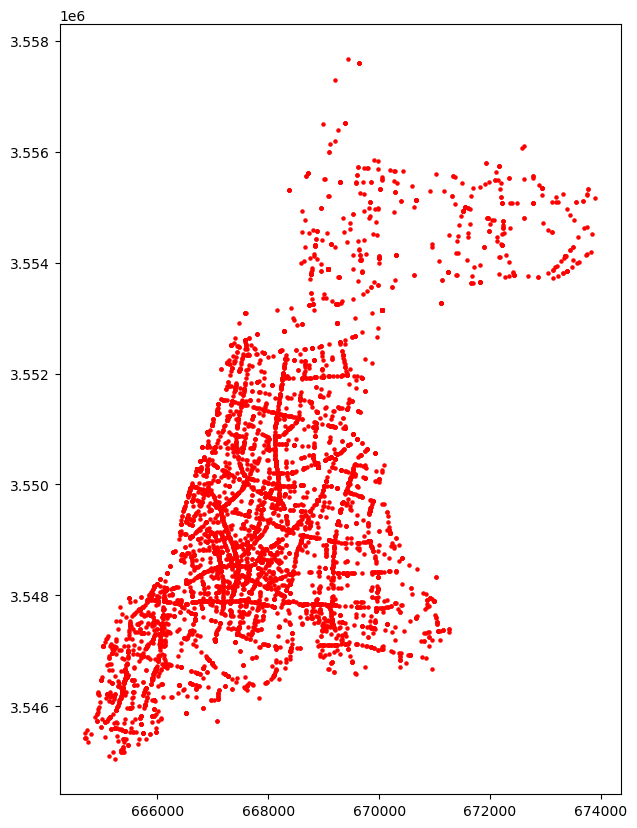

In [89]:
fig, ax = plt.subplots(figsize=(10, 10))
i_m_h_ta_mm_gdf.plot(ax=ax, color='red', marker='o', markersize=5 )
plt.show()

### Loading BP

In [90]:
bp_ta_bp_and_meta = gpd.read_parquet('./csv_tables/bp_ta_bp_and_meta.parquet')
bp_ta_bp_and_meta.head(5)

,oid_shvil,msorech,dateimport,create_year,shemmikta,create_date,geometry,width,direction,bitzua,miflas,date_created
0,1,95.10,14/08/2024 02:30:05,2012,נמיר מיוניצ'מן דרומה,None,"LINESTRING (669823.985 3557373.860, 669855.549...",2.5,דו סטרי,2012,None,None
1,2,201.14,14/08/2024 02:30:05,2013,פרופס מנמיר עד קדושי השואה,None,"LINESTRING (669232.834 3555478.027, 669169.381...",2.5,דו סטרי,2013,None,None
2,3,696.31,14/08/2024 02:30:05,2004,יאיר רוזנבלום מאורי צבי גרינברג עד פרופס,None,"LINESTRING (669232.637 3555478.023, 669249.025...",2.1,דו סטרי,2004,None,None
3,4,659.20,14/08/2024 02:30:05,2018,"קק""ל מנמיר עד חיים לבנון",None,"LINESTRING (669354.261 3555417.055, 669410.178...",2.5,דו סטרי,2018,מדרכה,None
4,5,362.67,14/08/2024 02:30:05,2018,רקנאטי בגינה מקרן קיימת לישראל עד אחימאיר,None,"LINESTRING (669946.350 3555344.516, 669962.261...",2.0,דו סטרי,2018,None,30/06/2018


#### Checking validity by lotting Quarters, Micro Mobility Accidents  and BP

In [91]:
i_m_h_ta_mm_gdf.crs

<Projected CRS: EPSG:32636>
Name: WGS 84 / UTM zone 36N
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: Between 30°E and 36°E, northern hemisphere between equator and 84°N, onshore and offshore. Belarus. Cyprus. Egypt. Ethiopia. Finland. Israel. Jordan. Kenya. Lebanon. Moldova. Norway. Russian Federation. Saudi Arabia. Sudan. Syria. Türkiye (Turkey). Uganda. Ukraine.
- bounds: (30.0, 0.0, 36.0, 84.0)
Coordinate Operation:
- name: UTM zone 36N
- method: Transverse Mercator
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

#### Plotting accidents with BP and Quarters

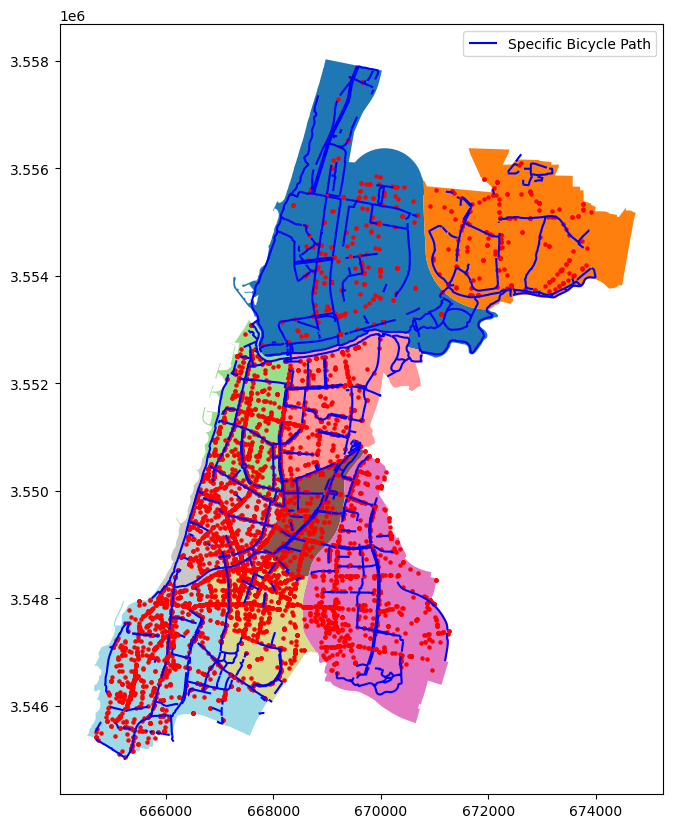

In [92]:
fig, ax = plt.subplots(figsize=(10, 10))

ta_q.plot(ax=ax, cmap='tab20', legend=True,)
bp_ta_bp_and_meta.plot(ax=ax, color='blue', label='Specific Bicycle Path')
i_m_h_ta_mm_gdf.plot(ax=ax, color='red', marker='o', markersize=5 )

plt.legend()
plt.show()

## Loading streets data


In [93]:
ta_streets = gpd.read_parquet('./csv_tables/ta_street_corrected.parquet')
ta_streets

,oidrechov,krechov,trechov,shemangli,mslamas,tsug,kkivun,UniqueId,shemarvit,kreka,geometry
0,1.0,915.0,הרוגי מלכות,HARUGEY MALKHOT,336.0,רחוב,0.0,507-10001,قتل مملكة,100.0,"LINESTRING (672865.880 3554095.253, 672895.216..."
1,2.0,0.0,0,UKNOWN,0.0,רחוב,3.0,507-10002,None,100.0,"LINESTRING (666990.498 3551436.940, 667065.337..."
2,3.0,265.0,אמסטרדם,AMSTERDAM,516.0,רחוב,1.0,507-10003,أمستردام,100.0,"LINESTRING (667879.712 3551424.162, 667940.741..."
3,4.0,644.0,אלון יגאל,YIG'AL ALLON,2524.0,רחוב,0.0,507-10004,ألون ييغال,200.0,"LINESTRING (669570.036 3550420.535, 669581.404..."
4,5.0,634.0,מרגולין,MARGOLIN,2649.0,רחוב,1.0,507-10005,مارغولين,100.0,"LINESTRING (669329.153 3548322.758, 669409.403..."
...,...,...,...,...,...,...,...,...,...,...,...
8874,9851.0,3007.0,שבטי ישראל,SHIVTEY YISRA'EL,1983.0,רחוב,0.0,507-17843,قبائل إسرائيل,100.0,"LINESTRING (665771.816 3547023.159, 665760.256..."
8875,9852.0,3058.0,אבינרי יצחק,AVINERY,2027.0,רחוב,0.0,507-20562,Avinri Yitzhak,100.0,"LINESTRING (665585.719 3547178.152, 665627.936..."
8876,9853.0,3058.0,אבינרי יצחק,AVINERY,2027.0,רחוב,0.0,507-20563,Avinri Yitzhak,100.0,"LINESTRING (665700.142 3547064.296, 665759.119..."
8877,9855.0,3907.0,3907,None,1703.0,רחוב,0.0,507-21960,3907,100.0,"LINESTRING (665087.059 3546677.092, 665075.120..."


#### Checking street length validity with google maps

In [94]:
ta_streets[ta_streets.shemangli == 'MARGOLIN'].geometry.length.sum()

690.5226685950398

#### Plotting streets with BP and MM Accidents and  Quarters

In [95]:

# fig, ax = plt.subplots(figsize=(30, 30))

# ta_streets.plot(ax=ax, cmap='tab20', legend=True, label='Specific Bicycle Path')
# ta_q.plot(ax=ax, cmap='tab20', legend=True,)
# bp_ta_bp_and_meta.plot(ax=ax, color='blue', label='Specific Bicycle Path')
# i_m_h_ta_mm_gdf.plot(ax=ax, color='black', marker='o', markersize=15 )


# plt.legend()
# plt.show()

Checking Location Accuracy

In [96]:
i_m_h_ta_gdf.location_accuracy.value_counts(normalize=True)

location_accuracy
1    0.512342
3    0.424395
2    0.063263
Name: proportion, dtype: float64

In [97]:
i_m_h_ta_mm_gdf.location_accuracy.value_counts(normalize=True)

location_accuracy
1    0.597338
3    0.379679
2    0.022983
Name: proportion, dtype: float64

In [98]:
i_m_h_ta_mm_gdf[i_m_h_ta_mm_gdf.accident_year.isin([2018,2019,2020,2021,2022,2023])].location_accuracy.value_counts(normalize=True)

location_accuracy
1    0.644453
3    0.335212
2    0.020334
Name: proportion, dtype: float64

1 = accurate coordinates<br>
2 = city center <br>
3 = street center

What we care is if the accident is accurate or if the accident is in the street center, why?

If the accident is in it's actual coordinates or if it's in the street center then that means it's in the quarter.

But a street can extend outside the quarter, so I need to make sure how many street intersect other quarters.

Currently I want to check street in 2 = city center, and will probably drop them.

In [99]:
i_m_h_ta_gdf[i_m_h_ta_gdf.location_accuracy == 2].x.value_counts()

x
180245.0    3094
180264.0    2357
180276.0    1265
178125.0      62
182556.0      55
184617.0      39
181651.0      21
181256.0      18
180108.0      16
184141.0      14
177917.0      13
179039.0      12
180029.0      10
182785.0       9
185394.0       9
184741.0       8
181582.0       6
178949.0       6
180697.0       6
178005.0       5
180219.0       5
184435.0       5
180560.0       3
183426.0       3
181104.0       3
181130.0       2
180368.0       1
181509.0       1
Name: count, dtype: int64

In [100]:
i_m_h_ta_gdf.shape

(111408, 162)

We should drop **location_accuracy** 2

---

Lets check **location_accuracy** 3

In [101]:
i_m_h_ta_gdf = i_m_h_ta_gdf[~(i_m_h_ta_gdf.location_accuracy == 2)].copy()
i_m_h_ta_gdf.shape

(104360, 162)

In [102]:
# fig, ax = plt.subplots(figsize=(30, 30))

# ta_streets.plot(ax=ax, cmap='tab20', legend=True, label='Specific Bicycle Path')
# ta_q.plot(ax=ax, cmap='tab20', legend=True,)
# bp_ta_bp_and_meta.plot(ax=ax, color='blue', label='Specific Bicycle Path')
# i_m_h_ta_gdf[i_m_h_ta_gdf.location_accuracy == 2].plot(ax=ax, color='black', marker='o', markersize=15 )


# plt.legend()
# plt.show()

#### Drop street in ta_streets with these names:

These streets were checked in **00_B_checking_streets_on_map.ipynb** and found to be not actually connected to streets.

* ו'
* ח'
* _*_
* 0
 

In [103]:
ta_streets = ta_streets[~ta_streets.trechov.isin(["ו'","ח'","*", "0"])].copy()

In [104]:
# fig, ax = plt.subplots(figsize=(30, 30))

# ta_streets.plot(ax=ax, cmap='tab20', legend=True, label='Specific Bicycle Path')
# ta_q.plot(ax=ax, cmap='tab20', legend=True,)
# bp_ta_bp_and_meta.plot(ax=ax, color='blue', label='Specific Bicycle Path')
# i_m_h_ta_gdf[i_m_h_ta_gdf.location_accuracy == 3].plot(ax=ax, color='black', marker='o', markersize=15 )


# plt.legend()
# plt.show()



Lets check how many streets intersect other quarters.

We will use streets_in_q that is created later on.

## Feature Engineering 

**BP and Accidents**<br>

    Adding cumulative BP and Cumulative accidents for each quarter

for each quarter:
* Get the area of each quarter
* get the length of all the BP in the quarter
* get the length of all the streets in the quarter

**Streets** 

    Adding total streets length for each quarter 
Side Note: I would do for each street but
* there is little data 
* data regarding which street is open is missing 
I don't think plotting this will be beneficial

Pearson Correlation between length of BP and number of accidents for each quarter

In [105]:
bp_ta_bp_and_meta

,oid_shvil,msorech,dateimport,create_year,shemmikta,create_date,geometry,width,direction,bitzua,miflas,date_created
0,1,95.10,14/08/2024 02:30:05,2012,נמיר מיוניצ'מן דרומה,None,"LINESTRING (669823.985 3557373.860, 669855.549...",2.5,דו סטרי,2012,None,None
1,2,201.14,14/08/2024 02:30:05,2013,פרופס מנמיר עד קדושי השואה,None,"LINESTRING (669232.834 3555478.027, 669169.381...",2.5,דו סטרי,2013,None,None
2,3,696.31,14/08/2024 02:30:05,2004,יאיר רוזנבלום מאורי צבי גרינברג עד פרופס,None,"LINESTRING (669232.637 3555478.023, 669249.025...",2.1,דו סטרי,2004,None,None
3,4,659.20,14/08/2024 02:30:05,2018,"קק""ל מנמיר עד חיים לבנון",None,"LINESTRING (669354.261 3555417.055, 669410.178...",2.5,דו סטרי,2018,מדרכה,None
4,5,362.67,14/08/2024 02:30:05,2018,רקנאטי בגינה מקרן קיימת לישראל עד אחימאיר,None,"LINESTRING (669946.350 3555344.516, 669962.261...",2.0,דו סטרי,2018,None,30/06/2018
...,...,...,...,...,...,...,...,...,...,...,...,...
866,462,197.41,14/08/2024 02:30:05,2014,שביל המוביל למרכז יצחק רבין,None,"LINESTRING (669777.502 3553114.882, 669733.916...",NaN,None,2014,None,None
867,463,2112.94,14/08/2024 02:30:05,-1,None,None,"LINESTRING (670193.904 3552876.389, 670151.903...",NaN,None,-1,None,None
868,464,44.95,14/08/2024 02:30:05,-1,None,None,"LINESTRING (669398.890 3552674.103, 669398.284...",NaN,None,-1,None,None
869,465,112.12,14/08/2024 02:30:05,-1,None,None,"LINESTRING (668324.626 3551551.690, 668319.918...",NaN,None,-1,None,None


### BP Feature Engineering 

#### Creating Cumulative BP with Accidents and Quarter

In [106]:
bp_ta_bp_and_meta['bp_length'] = bp_ta_bp_and_meta.geometry.length

In [107]:
# get all the bp in a quarter
bp_in_q = gpd.sjoin(bp_ta_bp_and_meta[['oid_shvil','shemmikta','bp_length','geometry','bitzua']], ta_q[['krova', 'geometry']], how='inner', predicate='intersects')

# We have more rows then original bp_ta_bp_and_meta since we have duplication and since
# since there are 47 duplicates(a bit ore then 5%) and most of them are on the same q, we can drop them
bp_in_q = bp_in_q.drop_duplicates(subset=['bp_length'])
bp_in_q

,oid_shvil,shemmikta,bp_length,geometry,bitzua,index_right,krova
0,1,נמיר מיוניצ'מן דרומה,95.089688,"LINESTRING (669823.985 3557373.860, 669855.549...",2012,0,1
1,2,פרופס מנמיר עד קדושי השואה,201.128828,"LINESTRING (669232.834 3555478.027, 669169.381...",2013,0,1
2,3,יאיר רוזנבלום מאורי צבי גרינברג עד פרופס,696.261026,"LINESTRING (669232.637 3555478.023, 669249.025...",2004,0,1
3,4,"קק""ל מנמיר עד חיים לבנון",659.153296,"LINESTRING (669354.261 3555417.055, 669410.178...",2018,0,1
4,5,רקנאטי בגינה מקרן קיימת לישראל עד אחימאיר,362.644518,"LINESTRING (669946.350 3555344.516, 669962.261...",2018,0,1
...,...,...,...,...,...,...,...
866,462,שביל המוביל למרכז יצחק רבין,197.392781,"LINESTRING (669777.502 3553114.882, 669733.916...",2014,0,1
867,463,None,2112.772412,"LINESTRING (670193.904 3552876.389, 670151.903...",-1,3,4
868,464,None,44.950912,"LINESTRING (669398.890 3552674.103, 669398.284...",-1,3,4
869,465,None,112.108111,"LINESTRING (668324.626 3551551.690, 668319.918...",-1,3,4


Making sure that BP that have no year of creation (bitzua) are unique and not actually related to other BP<br>
If they are unique, drop them.

In [108]:
bp_in_q[bp_in_q.oid_shvil.isin(bp_in_q[bp_in_q.bitzua == -1].oid_shvil)]

,oid_shvil,shemmikta,bp_length,geometry,bitzua,index_right,krova
818,419,None,7.148114,"LINESTRING (668405.407 3554224.806, 668398.271...",-1,0,1
819,420,None,235.178823,"LINESTRING (668328.569 3552403.104, 668215.470...",-1,2,3
820,421,None,110.085315,"LINESTRING (669671.803 3553011.534, 669678.363...",-1,3,4
821,422,None,135.646550,"LINESTRING (670743.348 3552413.244, 670743.408...",-1,3,4
825,426,אינשטיין מלישנסקי עד הגשר,319.429381,"LINESTRING (668722.847 3554258.059, 668645.585...",-1,0,1
828,429,None,74.291330,"LINESTRING (669114.211 3553307.829, 669119.029...",-1,0,1
829,430,None,28.706871,"LINESTRING (669139.697 3553260.352, 669168.290...",-1,0,1
830,431,None,5.463124,"LINESTRING (669177.650 3553267.796, 669173.921...",-1,0,1
831,432,None,19.641170,"LINESTRING (669171.699 3553253.385, 669172.367...",-1,0,1
832,433,None,29.649964,"LINESTRING (669174.747 3553223.387, 669162.198...",-1,0,1


In [109]:
# Making sure that not just oid is unique also name of bp
bp_in_q[bp_in_q.shemmikta.isin(bp_in_q[bp_in_q.bitzua == -1].dropna().shemmikta)]

,oid_shvil,shemmikta,bp_length,geometry,bitzua,index_right,krova
825,426,אינשטיין מלישנסקי עד הגשר,319.429381,"LINESTRING (668722.847 3554258.059, 668645.585...",-1,0,1
836,437,שניצר,435.287728,"LINESTRING (669177.008 3556117.864, 669172.205...",-1,0,1
838,439,קדושי השואה,554.091195,"LINESTRING (669077.515 3556061.715, 669071.257...",-1,0,1
858,456,הגדוד העברי מצ'לנוב עד הר ציון,172.749519,"LINESTRING (667661.811 3548450.710, 667698.700...",-1,7,8
864,460,חנה רובינא גדה דרומית,235.462831,"LINESTRING (671517.200 3555437.604, 671521.514...",-1,1,2


Bitzua with -1 is unique so I drop them all.

In [110]:
bp_in_q_bitzua_no_na = bp_in_q[~bp_in_q.oid_shvil.isin(bp_in_q[bp_in_q.bitzua == -1].oid_shvil)].copy()
bp_in_q_bitzua_no_na

,oid_shvil,shemmikta,bp_length,geometry,bitzua,index_right,krova
0,1,נמיר מיוניצ'מן דרומה,95.089688,"LINESTRING (669823.985 3557373.860, 669855.549...",2012,0,1
1,2,פרופס מנמיר עד קדושי השואה,201.128828,"LINESTRING (669232.834 3555478.027, 669169.381...",2013,0,1
2,3,יאיר רוזנבלום מאורי צבי גרינברג עד פרופס,696.261026,"LINESTRING (669232.637 3555478.023, 669249.025...",2004,0,1
3,4,"קק""ל מנמיר עד חיים לבנון",659.153296,"LINESTRING (669354.261 3555417.055, 669410.178...",2018,0,1
4,5,רקנאטי בגינה מקרן קיימת לישראל עד אחימאיר,362.644518,"LINESTRING (669946.350 3555344.516, 669962.261...",2018,0,1
...,...,...,...,...,...,...,...
860,457,יובל נאמן מלוי אשכול עד אייזיק שטרן,19.522751,"LINESTRING (668688.687 3554091.847, 668685.107...",2024,0,1
861,457,יובל נאמן מלוי אשכול עד אייזיק שטרן,135.518261,"LINESTRING (668612.378 3554202.585, 668617.080...",2024,0,1
863,459,יהודה עמיחי מיובל נאמן עד אייזיק שטרן,146.910140,"LINESTRING (668685.107 3554072.655, 668682.157...",2024,0,1
865,461,פארק גני יהושוע (רוקח),325.943424,"LINESTRING (670629.535 3553186.344, 670669.513...",2024,0,1


In [111]:
# Define the range for krova and bitzua
krova_range = range(1, 10)  # 1 to 9 inclusive
bitzua_range = range(2000, 2025)  # 2014 to 2023 inclusive

# Create a MultiIndex
index = pd.MultiIndex.from_product([krova_range, bitzua_range], names=['krova', 'bitzua'])

# Create a DataFrame with the MultiIndex
# Initialize with random data or zeros
bp_krova = pd.DataFrame( index=index)
bp_krova['bp_length'] = 0
# Display the DataFrame
bp_krova

bp_length
krova bitzua           
1     2000            0
      2001            0
      2002            0
      2003            0
      2004            0
...                 ...
9     2020            0
      2021            0
      2022            0
      2023            0
      2024            0

[225 rows x 1 columns]

In [112]:
# Ensure the DataFrame is sorted by 'krova' and 'year'
bp_in_q_bitzua_no_na_sort = bp_in_q_bitzua_no_na.sort_values(by=['krova', 'bitzua'])

# Calculate the cumulative sum
bp_krova['bp_length'] = bp_in_q_bitzua_no_na_sort.groupby(['krova', 'bitzua'])['bp_length'].sum()

bp_krova

bp_length
krova bitzua             
1     2000    1431.567191
      2001            NaN
      2002            NaN
      2003            NaN
      2004    4713.852363
...                   ...
9     2020    2081.540059
      2021    1509.641511
      2022     537.031651
      2023     171.426575
      2024            NaN

[225 rows x 1 columns]

In [113]:
bp_krova['cum_bp_length'] = bp_krova.groupby('krova')['bp_length'].cumsum()
bp_krova

bp_length  cum_bp_length
krova bitzua                            
1     2000    1431.567191    1431.567191
      2001            NaN            NaN
      2002            NaN            NaN
      2003            NaN            NaN
      2004    4713.852363    6145.419554
...                   ...            ...
9     2020    2081.540059   20832.869564
      2021    1509.641511   22342.511075
      2022     537.031651   22879.542727
      2023     171.426575   23050.969302
      2024            NaN            NaN

[225 rows x 2 columns]

In [114]:
# Forward fill NaN values with the previous non-NaN value for both columns
bp_krova['bp_length'] = bp_krova['bp_length'].ffill()
bp_krova['cum_bp_length'] = bp_krova['cum_bp_length'].ffill()

# Display the updated DataFrame
bp_krova


bp_length  cum_bp_length
krova bitzua                            
1     2000    1431.567191    1431.567191
      2001    1431.567191    1431.567191
      2002    1431.567191    1431.567191
      2003    1431.567191    1431.567191
      2004    4713.852363    6145.419554
...                   ...            ...
9     2020    2081.540059   20832.869564
      2021    1509.641511   22342.511075
      2022     537.031651   22879.542727
      2023     171.426575   23050.969302
      2024     171.426575   23050.969302

[225 rows x 2 columns]

In [115]:
bp_krova.xs(4, level='krova')

,bp_length,cum_bp_length
bitzua,,
2000,3652.646051,3652.646051
2001,3652.646051,3652.646051
2002,904.620455,4557.266506
2003,904.620455,4557.266506
2004,5954.678368,10511.944875
2005,5954.678368,10511.944875
2006,5954.678368,10511.944875
2007,5954.678368,10511.944875
2008,5954.678368,10511.944875


So we have
* bp length in each q over the years
* bp length cumulative in each q over the years
* q area


We also want number of accidents for each q over the years.<br>
For that I need:
* get the years of accidents in each q
* get the years of accidents for mm in in each q
* get the number of accidents in each q over the years
* get the number of mm accident in each q over the years

Then filter the bp_krova with the years.


In [116]:
# Spatial join of TA accidents and Quarters
i_m_h_ta_quarters_gdf = gpd.sjoin(i_m_h_ta_gdf, ta_q[['krova', 'geometry']], how='inner', predicate='intersects')
# i_m_h_ta_no_mm_quarters_gdf = gpd.sjoin(i_m_h_ta_no_mm_gdf, ta_q[['krova', 'geometry']], how='inner', predicate='intersects')
# i_m_h_ta_mm_quarters_gdf = gpd.sjoin(i_m_h_ta_mm_gdf, ta_q[['krova', 'geometry']], how='inner', predicate='intersects')

Some accidents have multiple injured, we want the number of accidents and not the number of injured.

We drop duplicates based on **provider_and_id** column.

In [117]:
i_m_h_ta_quarters_gdf.drop_duplicates('provider_and_id')

,accident_id,provider_and_id,provider_code,file_type_police,involved_type,involved_type_hebrew,license_acquiring_date,age_group,age_group_hebrew,sex,...,seats,total_weight,total_weight_hebrew,vehicle_damage,vehicle_damage_hebrew,urban_intersection,accident_date,geometry,index_right,krova
0,2013000873,12013000873,1,1,2,נהג נפגע,1980,11,50-54,1,...,99.0,NaN,None,3.0,קשה,14900823.0,2013-01-15 00:00:00,POINT (668409.481 3547041.256),7,8
1,2013002190,12013002190,1,1,1,נהג,0,99,לא ידוע,0,...,3.0,1.0,עד 1.9,4.0,אין נזק,NaN,2013-03-14 02:30:00,POINT (668159.628 3551290.697),3,4
2,2013000009,12013000009,1,1,3,נפגע,0,5,20-24,1,...,NaN,NaN,None,NaN,None,NaN,2013-01-08 00:00:00,POINT (667048.240 3548415.627),7,8
3,2013000194,12013000194,1,1,2,נהג נפגע,2000,7,30-34,2,...,99.0,1.0,עד 1.9,2.0,בינוני,20814.0,2013-05-08 00:00:00,POINT (667267.712 3548149.077),7,8
4,2013001938,12013001938,1,1,1,נהג,1996,8,35-39,1,...,99.0,1.0,עד 1.9,1.0,קל,NaN,2013-07-31 02:00:00,POINT (666709.392 3546594.486),8,7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
111352,2024097653,32024097653,3,3,2,נהג נפגע,1984,14,65-69,1,...,99.0,NaN,None,4.0,אין נזק,NaN,2024-05-06 09:00:00,POINT (668096.333 3546556.800),7,8
111355,2024096055,32024096055,3,3,2,נהג נפגע,1965,16,75-79,1,...,3.0,1.0,עד 1.9,4.0,אין נזק,NaN,2024-05-10 10:00:00,POINT (670615.062 3555490.482),0,1
111370,2024097401,32024097401,3,3,2,נהג נפגע,1994,11,50-54,1,...,3.0,1.0,עד 1.9,4.0,אין נזק,NaN,2024-01-30 02:30:00,POINT (668364.422 3547680.418),7,8
111391,2024095357,32024095357,3,3,2,נהג נפגע,2022,4,15-19,2,...,1.0,NaN,None,1.0,קל,NaN,2024-02-14 19:00:00,POINT (669081.430 3553164.789),0,1


### Streets Feature Engineering

#### Getting Streets Length and Cumulative Length

In [118]:
ta_streets['street_length'] = ta_streets.geometry.length
ta_streets

,oidrechov,krechov,trechov,shemangli,mslamas,tsug,kkivun,UniqueId,shemarvit,kreka,geometry,street_length
0,1.0,915.0,הרוגי מלכות,HARUGEY MALKHOT,336.0,רחוב,0.0,507-10001,قتل مملكة,100.0,"LINESTRING (672865.880 3554095.253, 672895.216...",32.805562
2,3.0,265.0,אמסטרדם,AMSTERDAM,516.0,רחוב,1.0,507-10003,أمستردام,100.0,"LINESTRING (667879.712 3551424.162, 667940.741...",63.283401
3,4.0,644.0,אלון יגאל,YIG'AL ALLON,2524.0,רחוב,0.0,507-10004,ألون ييغال,200.0,"LINESTRING (669570.036 3550420.535, 669581.404...",25.979540
4,5.0,634.0,מרגולין,MARGOLIN,2649.0,רחוב,1.0,507-10005,مارغولين,100.0,"LINESTRING (669329.153 3548322.758, 669409.403...",80.262574
5,6.0,744.0,דרך הטייסים,HATASSIM DERAKH,2601.0,דרך,0.0,507-10006,الطيارون,200.0,"LINESTRING (671221.294 3546942.086, 671204.846...",80.146523
...,...,...,...,...,...,...,...,...,...,...,...,...
8874,9851.0,3007.0,שבטי ישראל,SHIVTEY YISRA'EL,1983.0,רחוב,0.0,507-17843,قبائل إسرائيل,100.0,"LINESTRING (665771.816 3547023.159, 665760.256...",29.466544
8875,9852.0,3058.0,אבינרי יצחק,AVINERY,2027.0,רחוב,0.0,507-20562,Avinri Yitzhak,100.0,"LINESTRING (665585.719 3547178.152, 665627.936...",164.959426
8876,9853.0,3058.0,אבינרי יצחק,AVINERY,2027.0,רחוב,0.0,507-20563,Avinri Yitzhak,100.0,"LINESTRING (665700.142 3547064.296, 665759.119...",82.717053
8877,9855.0,3907.0,3907,None,1703.0,רחוב,0.0,507-21960,3907,100.0,"LINESTRING (665087.059 3546677.092, 665075.120...",31.021221


In [119]:
ta_streets.length.value_counts()

32.805562     1
21.970690     1
58.797077     1
24.403347     1
120.728025    1
             ..
217.242692    1
50.440688     1
31.780956     1
23.996072     1
43.847359     1
Name: count, Length: 8822, dtype: int64

Since each length is unique we will use it to drop any duplicates

Getting streets in each Quarter

In [120]:
streets_in_q = gpd.sjoin(ta_streets[['oidrechov','trechov','shemangli','kkivun', 'geometry','street_length']], ta_q[['krova', 'geometry']], how='inner', predicate='intersects')
streets_in_q

,oidrechov,trechov,shemangli,kkivun,geometry,street_length,index_right,krova
0,1.0,הרוגי מלכות,HARUGEY MALKHOT,0.0,"LINESTRING (672865.880 3554095.253, 672895.216...",32.805562,1,2
2,3.0,אמסטרדם,AMSTERDAM,1.0,"LINESTRING (667879.712 3551424.162, 667940.741...",63.283401,2,3
3,4.0,אלון יגאל,YIG'AL ALLON,0.0,"LINESTRING (669570.036 3550420.535, 669581.404...",25.979540,5,9
4,5.0,מרגולין,MARGOLIN,1.0,"LINESTRING (669329.153 3548322.758, 669409.403...",80.262574,5,9
5,6.0,דרך הטייסים,HATASSIM DERAKH,0.0,"LINESTRING (671221.294 3546942.086, 671204.846...",80.146523,5,9
...,...,...,...,...,...,...,...,...
8874,9851.0,שבטי ישראל,SHIVTEY YISRA'EL,0.0,"LINESTRING (665771.816 3547023.159, 665760.256...",29.466544,8,7
8875,9852.0,אבינרי יצחק,AVINERY,0.0,"LINESTRING (665585.719 3547178.152, 665627.936...",164.959426,8,7
8876,9853.0,אבינרי יצחק,AVINERY,0.0,"LINESTRING (665700.142 3547064.296, 665759.119...",82.717053,8,7
8877,9855.0,3907,None,0.0,"LINESTRING (665087.059 3546677.092, 665075.120...",31.021221,8,7


In [121]:
# Dropping duplicates
streets_in_q = streets_in_q.drop_duplicates(subset=['street_length'])
streets_in_q

,oidrechov,trechov,shemangli,kkivun,geometry,street_length,index_right,krova
0,1.0,הרוגי מלכות,HARUGEY MALKHOT,0.0,"LINESTRING (672865.880 3554095.253, 672895.216...",32.805562,1,2
2,3.0,אמסטרדם,AMSTERDAM,1.0,"LINESTRING (667879.712 3551424.162, 667940.741...",63.283401,2,3
3,4.0,אלון יגאל,YIG'AL ALLON,0.0,"LINESTRING (669570.036 3550420.535, 669581.404...",25.979540,5,9
4,5.0,מרגולין,MARGOLIN,1.0,"LINESTRING (669329.153 3548322.758, 669409.403...",80.262574,5,9
5,6.0,דרך הטייסים,HATASSIM DERAKH,0.0,"LINESTRING (671221.294 3546942.086, 671204.846...",80.146523,5,9
...,...,...,...,...,...,...,...,...
8874,9851.0,שבטי ישראל,SHIVTEY YISRA'EL,0.0,"LINESTRING (665771.816 3547023.159, 665760.256...",29.466544,8,7
8875,9852.0,אבינרי יצחק,AVINERY,0.0,"LINESTRING (665585.719 3547178.152, 665627.936...",164.959426,8,7
8876,9853.0,אבינרי יצחק,AVINERY,0.0,"LINESTRING (665700.142 3547064.296, 665759.119...",82.717053,8,7
8877,9855.0,3907,None,0.0,"LINESTRING (665087.059 3546677.092, 665075.120...",31.021221,8,7


#### Checking how many streets pass through multiple quarters.

In [122]:
street_rova_count = streets_in_q.groupby('trechov').krova.nunique().sort_values()

street_rova_count[street_rova_count > 1], street_rova_count[street_rova_count == 1]

(trechov
 תרצה                2
 בן יהודה            2
 חובבי ציון          2
 נחלת בנימין         2
 נחמני               2
                    ..
 דרך נמיר מרדכי      3
 הרצל                3
 אבן גבירול          4
 נתיבי אילון דרום    4
 נתיבי אילון צפון    6
 Name: krova, Length: 84, dtype: int64,
 trechov
 1024                       1
 מורשת                      1
 מורשת יהדות ליטא           1
 מושיע                      1
 מזל אריה                   1
                           ..
 דוידקה                     1
 ד'                         1
 ד"ר צ'רטוק שמשון           1
 דג'אני פואד איסמעיל ד"ר    1
 דה פיג'וטו                 1
 Name: krova, Length: 2429, dtype: int64)

In [123]:
street_rova_count[street_rova_count > 1].index

Index(['תרצה', 'בן יהודה', 'חובבי ציון', 'נחלת בנימין', 'נחמני', 'ויטל חיים',
       'בני דן', 'ז'בוטינסקי', 'ביל"ו', '1184', 'בלוך דוד', '1364',
       'סמטת שלוש', 'וולפסון', 'גולדברג', 'בר כוכבא', 'פנקס', 'השופטים',
       'המליץ', 'יפו העתיקה', 'מזא"ה', 'גת רימון', 'יצחק שדה',
       'דה וינצ'י לאונרדו', 'רוחמה', 'מוזס יהודה ונח', 'צייטלין', 'הירקון',
       'דובנוב', 'רמברנדט', 'אברבנאל', 'החשמונאים', 'קבוץ גלויות', 'הולכי רגל',
       'הוברמן', 'דרך בן צבי', 'דרך ההגנה', 'קרן קיימת לישראל', 'לבון פנחס',
       'קרליבך', 'דרך יגאל ידין', 'קויפמן יחזקאל', 'דרך שלמה', 'האטד', 'החשמל',
       'איילון צפון(רכבת)', 'המלך ג'ורג'', 'פינסקר', 'חיל השריון', 'ארלוזורוב',
       'ברזילי', 'הרברט סמואל', 'משפחת חלפי', 'על פרשת דרכים',
       'ברנשטיין לאונרד', 'חריפאי זהרירה', '3362', 'שור משה פרופ'', '3784',
       'הקישון', 'ערבי נחל', 'שד שאול המלך', 'אליפלט', 'יהודה המכבי',
       'יהודה הלוי', 'גולדמן נחום', 'הפטיש', 'מסילת וולפסון', 'שד דוד המלך',
       'סירקין', 'גבעת התחמושת', 'אלנבי

In [124]:
streets_in_q[streets_in_q.shemangli == 'UKNOWN'].shape

(0, 8)

In [125]:
streets_in_q[streets_in_q.trechov == '0'].shape

(0, 8)

In [126]:
streets_in_q[streets_in_q.trechov == '*'].shape

(0, 8)

84 streets pass more than 1 quarter.

Next questions:
* How many accidents that have **location_accuracy** 3 happen in those 84 streets?
    * this can help us determine how much to drop of the accidents
* What share of those 84 streets is in each quarter?
    * this can help us determine if an accident should be dropped, since if a street is 80% in a quarter, we can make an educated guess that the accident is inside that quarter.




In [127]:
# fig, ax = plt.subplots(figsize=(30, 30))

# ta_streets[ta_streets.shemangli == 'UKNOWN'].plot(ax=ax, cmap='tab20', legend=True, label='Specific Bicycle Path')
# ta_q.plot(ax=ax, cmap='tab20', legend=True,)
# # bp_ta_bp_and_meta.plot(ax=ax, color='blue', label='Specific Bicycle Path')
# i_m_h_ta_gdf.plot(ax=ax, color='black', marker='o', markersize=15 )


# plt.legend()
# plt.show()

In [128]:
# fig, ax = plt.subplots(figsize=(30, 30))

# ta_streets[ta_streets.trechov == '*'].plot(ax=ax, cmap='tab20', legend=True, label='Specific Bicycle Path')
# ta_q.plot(ax=ax, cmap='tab20', legend=True,)
# # bp_ta_bp_and_meta.plot(ax=ax, color='blue', label='Specific Bicycle Path')
# i_m_h_ta_gdf.plot(ax=ax, color='black', marker='o', markersize=15 )


# plt.legend()
# plt.show()

#### Getting quarter share for each street

In [129]:
# Getting streets with multi quarter
street_mult_rova_count = street_rova_count[street_rova_count > 1].copy()
street_mult_rova_count

trechov
תרצה                2
בן יהודה            2
חובבי ציון          2
נחלת בנימין         2
נחמני               2
                   ..
דרך נמיר מרדכי      3
הרצל                3
אבן גבירול          4
נתיבי אילון דרום    4
נתיבי אילון צפון    6
Name: krova, Length: 84, dtype: int64

In [130]:
streets_length = streets_in_q.groupby('trechov').street_length.sum()
streets_length

trechov
1024      86.281369
1063     303.830053
1073      74.114911
1080      96.933104
1099     100.731621
            ...    
תרצ"ו    124.415796
תרצה     262.971989
תש"ח     283.725915
תשבי     206.678152
תשרי     603.268779
Name: street_length, Length: 2513, dtype: float64

In [131]:
streets_in_q_ = streets_in_q.set_index('trechov')
streets_in_q_ 

,oidrechov,shemangli,kkivun,geometry,street_length,index_right,krova
trechov,,,,,,,
הרוגי מלכות,1.0,HARUGEY MALKHOT,0.0,"LINESTRING (672865.880 3554095.253, 672895.216...",32.805562,1,2
אמסטרדם,3.0,AMSTERDAM,1.0,"LINESTRING (667879.712 3551424.162, 667940.741...",63.283401,2,3
אלון יגאל,4.0,YIG'AL ALLON,0.0,"LINESTRING (669570.036 3550420.535, 669581.404...",25.979540,5,9
מרגולין,5.0,MARGOLIN,1.0,"LINESTRING (669329.153 3548322.758, 669409.403...",80.262574,5,9
דרך הטייסים,6.0,HATASSIM DERAKH,0.0,"LINESTRING (671221.294 3546942.086, 671204.846...",80.146523,5,9
...,...,...,...,...,...,...,...
שבטי ישראל,9851.0,SHIVTEY YISRA'EL,0.0,"LINESTRING (665771.816 3547023.159, 665760.256...",29.466544,8,7
אבינרי יצחק,9852.0,AVINERY,0.0,"LINESTRING (665585.719 3547178.152, 665627.936...",164.959426,8,7
אבינרי יצחק,9853.0,AVINERY,0.0,"LINESTRING (665700.142 3547064.296, 665759.119...",82.717053,8,7


In [132]:
streets_in_q_['total_street_length'] = streets_length

streets_in_q_['q_share_in_streets'] = streets_in_q_.street_length / streets_in_q_.total_street_length
streets_in_q_

,oidrechov,shemangli,kkivun,geometry,street_length,index_right,krova,total_street_length,q_share_in_streets
trechov,,,,,,,,,
הרוגי מלכות,1.0,HARUGEY MALKHOT,0.0,"LINESTRING (672865.880 3554095.253, 672895.216...",32.805562,1,2,349.591805,0.093840
אמסטרדם,3.0,AMSTERDAM,1.0,"LINESTRING (667879.712 3551424.162, 667940.741...",63.283401,2,3,305.605345,0.207076
אלון יגאל,4.0,YIG'AL ALLON,0.0,"LINESTRING (669570.036 3550420.535, 669581.404...",25.979540,5,9,2971.942967,0.008742
מרגולין,5.0,MARGOLIN,1.0,"LINESTRING (669329.153 3548322.758, 669409.403...",80.262574,5,9,690.522669,0.116235
דרך הטייסים,6.0,HATASSIM DERAKH,0.0,"LINESTRING (671221.294 3546942.086, 671204.846...",80.146523,5,9,2526.934508,0.031717
...,...,...,...,...,...,...,...,...,...
שבטי ישראל,9851.0,SHIVTEY YISRA'EL,0.0,"LINESTRING (665771.816 3547023.159, 665760.256...",29.466544,8,7,973.121921,0.030280
אבינרי יצחק,9852.0,AVINERY,0.0,"LINESTRING (665585.719 3547178.152, 665627.936...",164.959426,8,7,371.392067,0.444165
אבינרי יצחק,9853.0,AVINERY,0.0,"LINESTRING (665700.142 3547064.296, 665759.119...",82.717053,8,7,371.392067,0.222722


In [133]:
streets_in_q_ = streets_in_q_.reset_index()
streets_in_q_

,trechov,oidrechov,shemangli,kkivun,geometry,street_length,index_right,krova,total_street_length,q_share_in_streets
0,הרוגי מלכות,1.0,HARUGEY MALKHOT,0.0,"LINESTRING (672865.880 3554095.253, 672895.216...",32.805562,1,2,349.591805,0.093840
1,אמסטרדם,3.0,AMSTERDAM,1.0,"LINESTRING (667879.712 3551424.162, 667940.741...",63.283401,2,3,305.605345,0.207076
2,אלון יגאל,4.0,YIG'AL ALLON,0.0,"LINESTRING (669570.036 3550420.535, 669581.404...",25.979540,5,9,2971.942967,0.008742
3,מרגולין,5.0,MARGOLIN,1.0,"LINESTRING (669329.153 3548322.758, 669409.403...",80.262574,5,9,690.522669,0.116235
4,דרך הטייסים,6.0,HATASSIM DERAKH,0.0,"LINESTRING (671221.294 3546942.086, 671204.846...",80.146523,5,9,2526.934508,0.031717
...,...,...,...,...,...,...,...,...,...,...
8798,שבטי ישראל,9851.0,SHIVTEY YISRA'EL,0.0,"LINESTRING (665771.816 3547023.159, 665760.256...",29.466544,8,7,973.121921,0.030280
8799,אבינרי יצחק,9852.0,AVINERY,0.0,"LINESTRING (665585.719 3547178.152, 665627.936...",164.959426,8,7,371.392067,0.444165
8800,אבינרי יצחק,9853.0,AVINERY,0.0,"LINESTRING (665700.142 3547064.296, 665759.119...",82.717053,8,7,371.392067,0.222722
8801,3907,9855.0,None,0.0,"LINESTRING (665087.059 3546677.092, 665075.120...",31.021221,8,7,31.021221,1.000000


Now that we have the share we can look specifically on the streets that pass through multi quarters.

In [134]:
street_mult_rova_count[street_mult_rova_count == 2].index

Index(['תרצה', 'בן יהודה', 'חובבי ציון', 'נחלת בנימין', 'נחמני', 'ויטל חיים',
       'בני דן', 'ז'בוטינסקי', 'ביל"ו', '1184', 'בלוך דוד', '1364',
       'סמטת שלוש', 'וולפסון', 'גולדברג', 'בר כוכבא', 'פנקס', 'השופטים',
       'המליץ', 'יפו העתיקה', 'מזא"ה', 'גת רימון', 'יצחק שדה',
       'דה וינצ'י לאונרדו', 'רוחמה', 'מוזס יהודה ונח', 'צייטלין', 'הירקון',
       'דובנוב', 'רמברנדט', 'אברבנאל', 'החשמונאים', 'קבוץ גלויות', 'הולכי רגל',
       'הוברמן', 'דרך בן צבי', 'דרך ההגנה', 'קרן קיימת לישראל', 'לבון פנחס',
       'קרליבך', 'דרך יגאל ידין', 'קויפמן יחזקאל', 'דרך שלמה', 'האטד', 'החשמל',
       'איילון צפון(רכבת)', 'המלך ג'ורג'', 'פינסקר', 'חיל השריון', 'ארלוזורוב',
       'ברזילי', 'הרברט סמואל', 'משפחת חלפי', 'על פרשת דרכים',
       'ברנשטיין לאונרד', 'חריפאי זהרירה', '3362', 'שור משה פרופ'', '3784',
       'הקישון', 'ערבי נחל', 'שד שאול המלך', 'אליפלט', 'יהודה המכבי',
       'יהודה הלוי', 'גולדמן נחום', 'הפטיש', 'מסילת וולפסון', 'שד דוד המלך',
       'סירקין', 'גבעת התחמושת', 'אלנבי

In [135]:
streets_in_q_

,trechov,oidrechov,shemangli,kkivun,geometry,street_length,index_right,krova,total_street_length,q_share_in_streets
0,הרוגי מלכות,1.0,HARUGEY MALKHOT,0.0,"LINESTRING (672865.880 3554095.253, 672895.216...",32.805562,1,2,349.591805,0.093840
1,אמסטרדם,3.0,AMSTERDAM,1.0,"LINESTRING (667879.712 3551424.162, 667940.741...",63.283401,2,3,305.605345,0.207076
2,אלון יגאל,4.0,YIG'AL ALLON,0.0,"LINESTRING (669570.036 3550420.535, 669581.404...",25.979540,5,9,2971.942967,0.008742
3,מרגולין,5.0,MARGOLIN,1.0,"LINESTRING (669329.153 3548322.758, 669409.403...",80.262574,5,9,690.522669,0.116235
4,דרך הטייסים,6.0,HATASSIM DERAKH,0.0,"LINESTRING (671221.294 3546942.086, 671204.846...",80.146523,5,9,2526.934508,0.031717
...,...,...,...,...,...,...,...,...,...,...
8798,שבטי ישראל,9851.0,SHIVTEY YISRA'EL,0.0,"LINESTRING (665771.816 3547023.159, 665760.256...",29.466544,8,7,973.121921,0.030280
8799,אבינרי יצחק,9852.0,AVINERY,0.0,"LINESTRING (665585.719 3547178.152, 665627.936...",164.959426,8,7,371.392067,0.444165
8800,אבינרי יצחק,9853.0,AVINERY,0.0,"LINESTRING (665700.142 3547064.296, 665759.119...",82.717053,8,7,371.392067,0.222722
8801,3907,9855.0,None,0.0,"LINESTRING (665087.059 3546677.092, 665075.120...",31.021221,8,7,31.021221,1.000000


In [136]:
street_q_gb_share = streets_in_q_[streets_in_q_.trechov.isin(street_mult_rova_count.index)].groupby(['trechov','krova']).q_share_in_streets.sum()
street_q_gb_share

trechov        krova
1184           3        0.490229
               4        0.509771
1364           4        0.193263
               6        0.806737
3362           7        0.647371
                          ...   
שד שאול המלך   6        0.726506
שור משה פרופ'  3        0.221307
               4        0.778693
תרצה           5        0.119591
               7        0.880409
Name: q_share_in_streets, Length: 183, dtype: float64

In [137]:
street_q_gb_share[street_q_gb_share < 0.1]

trechov           krova
אבן גבירול        4        0.025725
                  6        0.018378
אילת              8        0.038775
אליפלט            5        0.067100
אלנבי             8        0.047173
בני דן            3        0.068463
דרך בגין          4        0.037204
דרך יגאל ידין     8        0.046275
דרך נמיר מרדכי    6        0.077183
החשמל             8        0.025094
חיל השריון        7        0.057869
יהודה המכבי       3        0.086986
יפו העתיקה        5        0.049191
לה גארדיה         6        0.026418
נתיבי אילון צפון  6        0.089431
                  8        0.098164
סמטת שלוש         7        0.067301
פנקס              3        0.061908
קויפמן יחזקאל     7        0.089066
שד רוקח           2        0.047879
                  3        0.020365
Name: q_share_in_streets, dtype: float64

In [138]:
street_q_gb_share_ = pd.DataFrame(street_q_gb_share).reset_index()
street_q_gb_share_[street_q_gb_share_.trechov == 'דרך בגין']

,trechov,krova,q_share_in_streets
51,דרך בגין,4,0.037204
52,דרך בגין,6,0.745329
53,דרך בגין,8,0.217466


These are the streets that have a share above 20% that pass through multi quarters.

Now lets check how many accidents they comprise.

In [154]:
streets_multi_q_high_share = street_q_gb_share_[(street_q_gb_share_.q_share_in_streets >  0.1) & (street_q_gb_share_.q_share_in_streets <  0.9)].trechov.unique()

streets_multi_q_high_share

array(['1184', '1364', '3362', '3784', 'אבן גבירול', 'אברבנאל',
       'איילון צפון(רכבת)', 'אילת', 'ארלוזורוב', 'ביל"ו', 'בלוך דוד',
       'בן יהודה', 'בר כוכבא', 'ברזילי', 'ברנשטיין לאונרד',
       'גבעת התחמושת', 'גולדברג', 'גולדמן נחום', 'גת רימון',
       "דה וינצ'י לאונרדו", 'דובנוב', 'דרך בגין', 'דרך בן צבי',
       'דרך ההגנה', 'דרך נמיר מרדכי', 'דרך שלמה', 'האטד', 'הוברמן',
       'הולכי רגל', 'החשמונאים', 'הירקון', 'המליץ', "המלך ג'ורג'",
       'הפטיש', 'הקישון', 'הרברט סמואל', 'הרכבת', 'הרצל', 'השופטים',
       'וולפסון', 'ויטל חיים', "ז'בוטינסקי", 'חובבי ציון',
       'חריפאי זהרירה', 'טשרניחובסקי', 'יהודה הלוי', 'יצחק שדה',
       'לבון פנחס', 'לה גארדיה', 'מוזס יהודה ונח', 'מזא"ה',
       'מסילת וולפסון', 'מקוה ישראל', 'משפחת חלפי', 'נחלת בנימין',
       'נחמני', 'נתיבי אילון דרום', 'נתיבי אילון צפון', 'סירקין',
       'על פרשת דרכים', 'ערבי נחל', 'פינסקר', 'צייטלין', 'קבוץ גלויות',
       'קרליבך', 'קרן קיימת לישראל', 'רוחמה', 'רמברנדט', 'שד דוד המלך',
       'שד שאול 

Not sure I can use the names of the streets since there might be changes in street name in i_m_h_ta_gdf vs ta_streets

Need to make sure we have the same streets.

In [155]:
street_in_imh_and_streets_multi_q_high_share = i_m_h_ta_gdf[i_m_h_ta_gdf.street1_hebrew.isin(streets_multi_q_high_share)].street1_hebrew.unique()

street_in_imh_and_streets_multi_q_high_share

array(['קבוץ גלויות', 'אבן גבירול', 'נחלת בנימין', 'בלוך דוד',
       'דרך נמיר מרדכי', 'הרצל', "המלך ג'ורג'", 'קרליבך', 'לה גארדיה',
       'הירקון', 'ערבי נחל', 'החשמונאים', 'יהודה הלוי', 'מקוה ישראל',
       'יצחק שדה', 'דרך בגין', 'בן יהודה', 'דרך בן צבי', 'ארלוזורוב',
       'הרכבת', 'דרך שלמה', 'קרן קיימת לישראל', 'דרך ההגנה',
       'גולדמן נחום', 'גבעת התחמושת', 'הקישון', "ז'בוטינסקי",
       'שד שאול המלך', 'פינסקר', 'טשרניחובסקי', 'אילת', 'לבון פנחס',
       "דה וינצ'י לאונרדו", 'בר כוכבא', 'על פרשת דרכים', 'שד דוד המלך',
       'ביל"ו', 'מזא"ה', 'וולפסון', 'נחמני', 'אברבנאל', 'דובנוב',
       'חובבי ציון', 'מוזס יהודה ונח', 'ברזילי', 'ויטל חיים', 'רוחמה',
       'הוברמן', 'רמברנדט', 'צייטלין', 'השופטים', 'סירקין', 'הפטיש',
       'גולדברג', 'גת רימון', 'תרצה', 'המליץ'], dtype=object)

In [156]:
np.setdiff1d(streets_multi_q_high_share, street_in_imh_and_streets_multi_q_high_share)

array(['1184', '1364', '3362', '3784', 'איילון צפון(רכבת)',
       'ברנשטיין לאונרד', 'האטד', 'הולכי רגל', 'הרברט סמואל',
       'חריפאי זהרירה', 'מסילת וולפסון', 'משפחת חלפי', 'נתיבי אילון דרום',
       'נתיבי אילון צפון', "שור משה פרופ'"], dtype=object)

Made sure the streets that don't show up in i_m_h_ta_gdf don't have accidents, seems OK.

Now we can check how many accidents occurred.

In [157]:
i_m_h_ta_gdf.shape,i_m_h_ta_gdf[i_m_h_ta_gdf.street1_hebrew.isin(streets_multi_q_high_share)].shape

((104360, 162), (33928, 162))

Checking more specific each street number of accidents. 

In [158]:
i_m_h_ta_gdf[i_m_h_ta_gdf.street1_hebrew.isin(streets_multi_q_high_share)].street1_hebrew.value_counts()

street1_hebrew
דרך נמיר מרדכי       3409
דרך בגין             3227
אבן גבירול           2881
קבוץ גלויות          2123
לה גארדיה            1797
הירקון               1750
ארלוזורוב            1637
דרך בן צבי           1535
דרך שלמה             1505
דרך ההגנה            1244
בן יהודה             1191
יצחק שדה             1108
הרצל                 1019
שד שאול המלך          856
המלך ג'ורג'           813
קרן קיימת לישראל      771
יהודה הלוי            769
הרכבת                 678
החשמונאים             598
אילת                  538
ז'בוטינסקי            448
קרליבך                439
על פרשת דרכים         390
נחלת בנימין           373
גבעת התחמושת          341
גולדמן נחום           299
שד דוד המלך           201
בלוך דוד              185
דה וינצ'י לאונרדו     184
דובנוב                141
ערבי נחל              139
לבון פנחס             136
אברבנאל               107
נחמני                 105
פינסקר                104
מוזס יהודה ונח        103
וולפסון                98
מזא"ה                  

In [159]:
i_m_h_ta_mm_gdf[i_m_h_ta_mm_gdf.street1_hebrew.isin(streets_multi_q_high_share)].street1_hebrew.value_counts()

street1_hebrew
אבן גבירול           315
דרך בגין             261
דרך שלמה             193
דרך נמיר מרדכי       178
דרך ההגנה            156
קבוץ גלויות          137
המלך ג'ורג'          124
בן יהודה             114
ארלוזורוב            111
יצחק שדה             107
הירקון               107
הרצל                 104
דרך בן צבי            85
לה גארדיה             81
יהודה הלוי            75
שד שאול המלך          73
הרכבת                 62
אילת                  61
נחלת בנימין           60
החשמונאים             54
גולדמן נחום           41
קרליבך                38
בלוך דוד              36
ז'בוטינסקי            33
גבעת התחמושת          29
קרן קיימת לישראל      27
על פרשת דרכים         26
אברבנאל               21
שד דוד המלך           21
דה וינצ'י לאונרדו     15
לבון פנחס             12
פינסקר                11
הוברמן                11
מוזס יהודה ונח        11
טשרניחובסקי           10
ערבי נחל               9
דובנוב                 9
וולפסון                9
מקוה ישראל             8
נחמני     

### Changing q of accidents on multi q streets in **i_m_h_ta_quarters_gdf**

We currently have 30 thousand lines in **i_m_h_ta_gdf**, we cannot drop 30% of our accidents.<br>
Instead we will change the q of accidents to be proportional to their share.

In [153]:
street_q_gb_share_[(street_q_gb_share_.q_share_in_streets >  0.1) & (street_q_gb_share_.q_share_in_streets <  0.9)]

,trechov,krova,q_share_in_streets
0,1184,3,0.490229
1,1184,4,0.509771
2,1364,4,0.193263
3,1364,6,0.806737
4,3362,7,0.647371
...,...,...,...
178,שד שאול המלך,6,0.726506
179,שור משה פרופ',3,0.221307
180,שור משה פרופ',4,0.778693
181,תרצה,5,0.119591


In [145]:
# get the rows with streets that are multi
i_m_h_ta_quarters_gdf[i_m_h_ta_quarters_gdf.street1_hebrew.isin(streets_multi_q_high_share)]

,accident_id,provider_and_id,provider_code,file_type_police,involved_type,involved_type_hebrew,license_acquiring_date,age_group,age_group_hebrew,sex,...,seats,total_weight,total_weight_hebrew,vehicle_damage,vehicle_damage_hebrew,urban_intersection,accident_date,geometry,index_right,krova
0,2013000873,12013000873,1,1,2,נהג נפגע,1980,11,50-54,1,...,99.0,NaN,None,3.0,קשה,14900823.0,2013-01-15 00:00:00,POINT (668409.481 3547041.256),7,8
1,2013002190,12013002190,1,1,1,נהג,0,99,לא ידוע,0,...,3.0,1.0,עד 1.9,4.0,אין נזק,NaN,2013-03-14 02:30:00,POINT (668159.628 3551290.697),3,4
3,2013000194,12013000194,1,1,2,נהג נפגע,2000,7,30-34,2,...,99.0,1.0,עד 1.9,2.0,בינוני,20814.0,2013-05-08 00:00:00,POINT (667267.712 3548149.077),7,8
6,2013002190,12013002190,1,1,1,נהג,0,99,לא ידוע,0,...,99.0,0.0,לא ידוע,4.0,אין נזק,NaN,2013-03-14 02:30:00,POINT (668159.628 3551290.697),3,4
25,2013000147,12013000147,1,1,1,נהג,2004,6,25-29,1,...,3.0,1.0,עד 1.9,2.0,בינוני,9110323.0,2013-09-19 00:00:00,POINT (668158.751 3551284.678),3,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
111376,2024095468,32024095468,3,3,1,נהג,1992,11,50-54,1,...,3.0,2.0,2.0-2.9,4.0,אין נזק,NaN,2024-03-07 14:30:00,POINT (667433.903 3547308.367),7,8
111382,2024097734,32024097734,3,3,1,נהג,0,99,לא ידוע,0,...,3.0,1.0,עד 1.9,4.0,אין נזק,NaN,2024-03-03 13:15:00,POINT (667993.398 3551643.343),2,3
111388,2024092662,32024092662,3,3,2,נהג נפגע,1997,9,40-44,1,...,3.0,2.0,2.0-2.9,1.0,קל,NaN,2024-02-02 14:30:00,POINT (668388.578 3550218.238),3,4
111390,2024091837,32024091837,3,3,1,נהג,0,99,לא ידוע,0,...,3.0,2.0,2.0-2.9,4.0,אין נזק,NaN,2024-03-05 00:30:00,POINT (669378.213 3550242.466),5,9


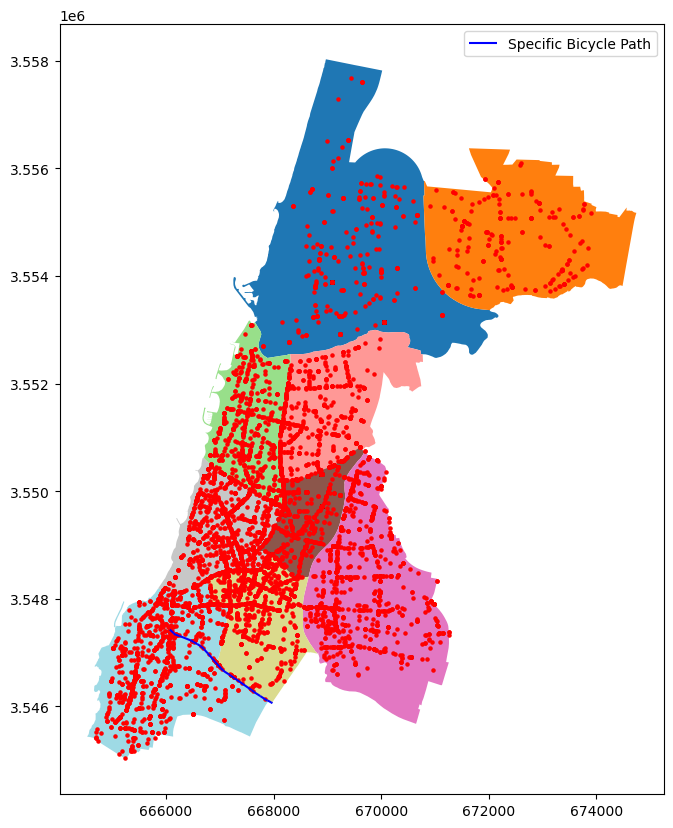

In [ ]:
fig, ax = plt.subplots(figsize=(10, 10))

ta_q.plot(ax=ax, cmap='tab20', legend=True,)
# bp_ta_bp_and_meta.plot(ax=ax, color='blue', label='Specific Bicycle Path')
streets_in_q_[streets_in_q_.index == 'דרך בן צבי'].plot(ax=ax, color='blue', label='Specific Bicycle Path')
i_m_h_ta_mm_gdf.plot(ax=ax, color='red', marker='o', markersize=5 )

plt.legend()
plt.show()

In [37]:
# This should replace i_m_h_ta_q_gb_krova
num_acc_in_q       = pd.DataFrame(i_m_h_ta_quarters_gdf.drop_duplicates('provider_and_id').groupby(['krova', 'accident_year']).size(), columns=['all_accident_cnt'])
num_acc_no_mm_in_q = pd.DataFrame(i_m_h_ta_no_mm_quarters_gdf.drop_duplicates('provider_and_id').groupby(['krova', 'accident_year']).size(),columns=['no_mm_accident_cnt'])
num_acc_mm_in_q    = pd.DataFrame(i_m_h_ta_mm_quarters_gdf.groupby(['krova', 'accident_year']).size(),columns=['mm_accident_cnt'])

num_injured_in_q       = pd.DataFrame(i_m_h_ta_quarters_gdf.groupby(['krova', 'accident_year']).size(), columns=['injured_all_cnt'])
num_injured_no_mm_in_q = pd.DataFrame(i_m_h_ta_no_mm_quarters_gdf.groupby(['krova', 'accident_year']).size(),columns=['injured_no_mm_cnt'])
num_injured_mm_in_q    = pd.DataFrame(i_m_h_ta_mm_quarters_gdf.groupby(['krova', 'accident_year']).size(),columns=['injured_mm_cnt'])

i_m_h_ta_q_gb_krova = pd.DataFrame(i_m_h_ta_quarters_gdf.groupby(['krova', 'accident_year']).size(), columns=['all_accident_cnt'])
i_m_h_ta_no_mm_q_gb_krova = pd.DataFrame(i_m_h_ta_no_mm_quarters_gdf.groupby(['krova', 'accident_year']).size(),columns=['no_mm_accident_cnt'])
i_m_h_ta_mm_q_gb_krova = pd.DataFrame(i_m_h_ta_mm_quarters_gdf.groupby(['krova', 'accident_year']).size(),columns=['mm_accident_cnt'])
i_m_h_ta_q_gb_krova

all_accident_cnt
krova accident_year                  
1     2013                       1391
      2014                       1099
      2015                       1271
      2016                       1143
      2017                       1105
...                               ...
9     2020                       1094
      2021                       1157
      2022                       1187
      2023                       1088
      2024                        422

[108 rows x 1 columns]

In [38]:
num_injured_in_q

injured_all_cnt
krova accident_year                 
1     2013                      1391
      2014                      1099
      2015                      1271
      2016                      1143
      2017                      1105
...                              ...
9     2020                      1094
      2021                      1157
      2022                      1187
      2023                      1088
      2024                       422

[108 rows x 1 columns]

In [39]:
# trying to assign the accident_cnt to bp_krova
bp_krova['all_acc_cnt'] = 0
bp_krova['no_mm_acc_cnt'] = 0
bp_krova['mm_acc_cnt'] = 0

bp_krova['injured_all_cnt']    = 0
bp_krova['injured_no_mm_cnt']  = 0
bp_krova['injured_mm_cnt']     = 0


# adding columns to bp_krova
bp_krova['all_acc_cnt']   = num_acc_in_q['all_accident_cnt']
bp_krova['no_mm_acc_cnt'] = num_acc_no_mm_in_q['no_mm_accident_cnt']
bp_krova['mm_acc_cnt']    = num_acc_mm_in_q['mm_accident_cnt']

bp_krova['injured_all_cnt']    = num_injured_in_q['injured_all_cnt']
bp_krova['injured_no_mm_cnt']  = num_injured_no_mm_in_q['injured_no_mm_cnt']
bp_krova['injured_mm_cnt']     = num_injured_mm_in_q['injured_mm_cnt']
bp_krova

bp_length  cum_bp_length  all_acc_cnt  no_mm_acc_cnt  \
krova bitzua                                                           
1     2000    1431.567191    1431.567191          NaN            NaN   
      2001    1431.567191    1431.567191          NaN            NaN   
      2002    1431.567191    1431.567191          NaN            NaN   
      2003    1431.567191    1431.567191          NaN            NaN   
      2004    4713.852363    6145.419554          NaN            NaN   
...                   ...            ...          ...            ...   
9     2020    2081.540059   20832.869564        543.0          538.0   
      2021    1509.641511   22342.511075        562.0          553.0   
      2022     537.031651   22879.542727        570.0          566.0   
      2023     171.426575   23050.969302        542.0          530.0   
      2024     171.426575   23050.969302        207.0          205.0   

              mm_acc_cnt  injured_all_cnt  injured_no_mm_cnt  injured_mm_cnt  
krova bitzua                                                                  
1     2000           NaN              NaN                NaN             NaN  
      2001           NaN              NaN                NaN             NaN  
      2002           NaN              NaN                NaN             NaN  
      2003           NaN              NaN                NaN             NaN  
      2004           NaN              NaN                NaN             NaN  
...                  ...              ...                ...             ...  
9     2020         104.0           1094.0              990.0           104.0  
      2021         115.0           1157.0             1042.0           115.0  
      2022         120.0           1187.0             1067.0           120.0  
      2023         107.0           1088.0              981.0           107.0  
      2024          39.0            422.0              383.0            39.0  

[225 rows x 8 columns]

In [40]:
bp_krova.xs(3, level='krova')

,bp_length,cum_bp_length,all_acc_cnt,no_mm_acc_cnt,mm_acc_cnt,injured_all_cnt,injured_no_mm_cnt,injured_mm_cnt
bitzua,,,,,,,,
2000,2393.581055,2393.581055,NaN,NaN,NaN,NaN,NaN,NaN
2001,2393.581055,2393.581055,NaN,NaN,NaN,NaN,NaN,NaN
2002,914.986474,3308.567529,NaN,NaN,NaN,NaN,NaN,NaN
2003,914.986474,3308.567529,NaN,NaN,NaN,NaN,NaN,NaN
2004,2527.949327,5836.516856,NaN,NaN,NaN,NaN,NaN,NaN
2005,2527.949327,5836.516856,NaN,NaN,NaN,NaN,NaN,NaN
2006,2527.949327,5836.516856,NaN,NaN,NaN,NaN,NaN,NaN
2007,2527.949327,5836.516856,NaN,NaN,NaN,NaN,NaN,NaN
2008,2527.949327,5836.516856,NaN,NaN,NaN,NaN,NaN,NaN


In [41]:
# Filter the DataFrame to keep only rows where bitzua is 2013 or greater
bp_krova_filtered = bp_krova.loc[bp_krova.index.get_level_values('bitzua') >= 2013].copy()

# Display the filtered DataFrame
bp_krova_filtered
bp_krova_filtered.xs(3, level='krova')

,bp_length,cum_bp_length,all_acc_cnt,no_mm_acc_cnt,mm_acc_cnt,injured_all_cnt,injured_no_mm_cnt,injured_mm_cnt
bitzua,,,,,,,,
2013,2608.205283,8444.722139,573.0,569.0,41.0,1153.0,1112.0,41.0
2014,2608.205283,8444.722139,510.0,505.0,79.0,1050.0,971.0,79.0
2015,2608.205283,8444.722139,492.0,490.0,53.0,1009.0,956.0,53.0
2016,2608.205283,8444.722139,528.0,525.0,91.0,1077.0,986.0,91.0
2017,2608.205283,8444.722139,478.0,473.0,88.0,944.0,856.0,88.0
2018,257.426020,8702.148159,422.0,420.0,84.0,864.0,780.0,84.0
2019,257.426020,8702.148159,364.0,358.0,95.0,726.0,631.0,95.0
2020,1176.904473,9879.052632,321.0,310.0,84.0,636.0,552.0,84.0
2021,4378.072371,14257.125003,322.0,306.0,104.0,654.0,550.0,104.0


In [42]:
# Calculating Cum Sum
bp_krova_filtered['cum_all_acc_cnt'] = bp_krova_filtered.groupby('krova')['all_acc_cnt'].cumsum()
bp_krova_filtered['cum_no_mm_acc_cnt'] = bp_krova_filtered.groupby('krova')['no_mm_acc_cnt'].cumsum()
bp_krova_filtered['cum_mm_acc_cnt'] = bp_krova_filtered.groupby('krova')['mm_acc_cnt'].cumsum()

bp_krova_filtered['cum_all_injured_cnt'] = bp_krova_filtered.groupby('krova')['injured_all_cnt'].cumsum()
bp_krova_filtered['cum_no_mm_injured_cnt'] = bp_krova_filtered.groupby('krova')['injured_no_mm_cnt'].cumsum()
bp_krova_filtered['cum_mm_injured_cnt'] = bp_krova_filtered.groupby('krova')['injured_mm_cnt'].cumsum()


bp_krova_filtered

bp_length  cum_bp_length  all_acc_cnt  no_mm_acc_cnt  \
krova bitzua                                                           
1     2013    4613.175246   15716.611624        604.0          607.0   
      2014     758.026089   16474.637713        505.0          509.0   
      2015    2335.205547   18809.843260        562.0          568.0   
      2016     498.878369   19308.721628        497.0          499.0   
      2017    4680.392487   23989.114115        503.0          499.0   
...                   ...            ...          ...            ...   
9     2020    2081.540059   20832.869564        543.0          538.0   
      2021    1509.641511   22342.511075        562.0          553.0   
      2022     537.031651   22879.542727        570.0          566.0   
      2023     171.426575   23050.969302        542.0          530.0   
      2024     171.426575   23050.969302        207.0          205.0   

              mm_acc_cnt  injured_all_cnt  injured_no_mm_cnt  injured_mm_cnt  \
krova bitzua                                                                   
1     2013          39.0           1391.0             1360.0            39.0   
      2014          35.0           1099.0             1074.0            35.0   
      2015          45.0           1271.0             1244.0            45.0   
      2016          45.0           1143.0             1114.0            45.0   
      2017          60.0           1105.0             1048.0            60.0   
...                  ...              ...                ...             ...   
9     2020         104.0           1094.0              990.0           104.0   
      2021         115.0           1157.0             1042.0           115.0   
      2022         120.0           1187.0             1067.0           120.0   
      2023         107.0           1088.0              981.0           107.0   
      2024          39.0            422.0              383.0            39.0   

              cum_all_acc_cnt  cum_no_mm_acc_cnt  cum_mm_acc_cnt  \
krova bitzua                                                       
1     2013              604.0              607.0            39.0   
      2014             1109.0             1116.0            74.0   
      2015             1671.0             1684.0           119.0   
      2016             2168.0             2183.0           164.0   
      2017             2671.0             2682.0           224.0   
...                       ...                ...             ...   
9     2020             6027.0             6016.0           855.0   
      2021             6589.0             6569.0           970.0   
      2022             7159.0             7135.0          1090.0   
      2023             7701.0             7665.0          1197.0   
      2024             7908.0             7870.0          1236.0   

              cum_all_injured_cnt  cum_no_mm_injured_cnt  cum_mm_injured_cnt  
krova bitzua                                                                  
1     2013                 1391.0                 1360.0                39.0  
      2014                 2490.0                 2434.0                74.0  
      2015                 3761.0                 3678.0               119.0  
      2016                 4904.0                 4792.0               164.0  
      2017                 6009.0                 5840.0               224.0  
...                           ...                    ...                 ...  
9     2020                12256.0                11451.0               855.0  
      2021                13413.0                12493.0               970.0  
      2022                14600.0                13560.0              1090.0  
      2023                15688.0                14541.0              1197.0  
      2024                16110.0                14924.0              1236.0  

[108 rows x 14 columns]

In [43]:
# Calculating Ratio
bp_krova_filtered['r_all_acc_bp_len'] = bp_krova_filtered['cum_all_acc_cnt'] / bp_krova_filtered['cum_bp_length']
bp_krova_filtered['r_no_mm_acc_bp_len'] = bp_krova_filtered['cum_no_mm_acc_cnt'] / bp_krova_filtered['cum_bp_length']
bp_krova_filtered['r_mm_acc_bp_len'] = bp_krova_filtered['cum_mm_acc_cnt'] / bp_krova_filtered['cum_bp_length']

bp_krova_filtered['r_all_injured_bp_len'] = bp_krova_filtered['cum_all_injured_cnt'] / bp_krova_filtered['cum_bp_length']
bp_krova_filtered['r_no_mm_injured_bp_len'] = bp_krova_filtered['cum_no_mm_injured_cnt'] / bp_krova_filtered['cum_bp_length']
bp_krova_filtered['r_mm_injured_bp_len'] = bp_krova_filtered['cum_mm_injured_cnt'] / bp_krova_filtered['cum_bp_length']

bp_krova_filtered

bp_length  cum_bp_length  all_acc_cnt  no_mm_acc_cnt  \
krova bitzua                                                           
1     2013    4613.175246   15716.611624        604.0          607.0   
      2014     758.026089   16474.637713        505.0          509.0   
      2015    2335.205547   18809.843260        562.0          568.0   
      2016     498.878369   19308.721628        497.0          499.0   
      2017    4680.392487   23989.114115        503.0          499.0   
...                   ...            ...          ...            ...   
9     2020    2081.540059   20832.869564        543.0          538.0   
      2021    1509.641511   22342.511075        562.0          553.0   
      2022     537.031651   22879.542727        570.0          566.0   
      2023     171.426575   23050.969302        542.0          530.0   
      2024     171.426575   23050.969302        207.0          205.0   

              mm_acc_cnt  injured_all_cnt  injured_no_mm_cnt  injured_mm_cnt  \
krova bitzua                                                                   
1     2013          39.0           1391.0             1360.0            39.0   
      2014          35.0           1099.0             1074.0            35.0   
      2015          45.0           1271.0             1244.0            45.0   
      2016          45.0           1143.0             1114.0            45.0   
      2017          60.0           1105.0             1048.0            60.0   
...                  ...              ...                ...             ...   
9     2020         104.0           1094.0              990.0           104.0   
      2021         115.0           1157.0             1042.0           115.0   
      2022         120.0           1187.0             1067.0           120.0   
      2023         107.0           1088.0              981.0           107.0   
      2024          39.0            422.0              383.0            39.0   

              cum_all_acc_cnt  cum_no_mm_acc_cnt  cum_mm_acc_cnt  \
krova bitzua                                                       
1     2013              604.0              607.0            39.0   
      2014             1109.0             1116.0            74.0   
      2015             1671.0             1684.0           119.0   
      2016             2168.0             2183.0           164.0   
      2017             2671.0             2682.0           224.0   
...                       ...                ...             ...   
9     2020             6027.0             6016.0           855.0   
      2021             6589.0             6569.0           970.0   
      2022             7159.0             7135.0          1090.0   
      2023             7701.0             7665.0          1197.0   
      2024             7908.0             7870.0          1236.0   

              cum_all_injured_cnt  cum_no_mm_injured_cnt  cum_mm_injured_cnt  \
krova bitzua                                                                   
1     2013                 1391.0                 1360.0                39.0   
      2014                 2490.0                 2434.0                74.0   
      2015                 3761.0                 3678.0               119.0   
      2016                 4904.0                 4792.0               164.0   
      2017                 6009.0                 5840.0               224.0   
...                           ...                    ...                 ...   
9     2020                12256.0                11451.0               855.0   
      2021                13413.0                12493.0               970.0   
      2022                14600.0                13560.0              1090.0   
      2023                15688.0                14541.0              1197.0   
      2024                16110.0                14924.0              1236.0   

              r_all_acc_bp_len  r_no_mm_acc_bp_len  r_mm_acc_bp_len  \
krova bitzua                             

### Quarters Feature Engineering

#### Polygone Area

In [44]:
# area of each quarter
ta_q['area'] = ta_q.geometry.area
ta_q

,oidrova,krova,dateimport,ShapeArea,geometry,index,area
0,1,1,01/12/2015 02:28:14,1.301654e+07,"POLYGON ((670795.655 3555762.452, 670797.577 3...",0,1.301456e+07
1,2,2,01/12/2015 02:28:14,8.013404e+06,"POLYGON ((672021.029 3553364.492, 672014.690 3...",1,8.012438e+06
2,3,3,01/12/2015 02:28:14,3.380430e+06,"POLYGON ((668311.070 3552547.701, 668311.229 3...",2,3.379848e+06
3,4,4,01/12/2015 02:28:14,4.510255e+06,"POLYGON ((670771.828 3552544.564, 670771.584 3...",3,4.509556e+06
4,5,6,01/12/2015 02:28:14,2.089044e+06,"POLYGON ((668160.048 3550196.192, 668162.425 3...",4,2.088708e+06
5,6,9,01/12/2015 02:28:14,7.879856e+06,"POLYGON ((668811.121 3546980.368, 668808.698 3...",5,7.878684e+06
6,7,5,01/12/2015 02:28:14,3.024297e+06,"POLYGON ((666698.783 3550619.396, 666701.339 3...",6,3.023758e+06
7,8,8,01/12/2015 02:28:14,3.420996e+06,"POLYGON ((667954.133 3548820.374, 667956.725 3...",7,3.420414e+06
8,9,7,01/12/2015 02:28:14,6.343551e+06,"POLYGON ((665854.540 3548193.053, 665868.137 3...",8,6.342357e+06


#### How many accidents that have **location_accuracy** 3 happen in those 84 streets?

In [182]:
street_mult_rova_count.index

Index(['בן יהודה', 'תרצה', '1364', 'וולפסון', 'סירקין', 'נחלת בנימין',
       'סמטת שלוש', 'השופטים', 'נחמני', '1184', 'בני דן', 'בלוך דוד', 'ביל"ו',
       'ויטל חיים', 'ז'בוטינסקי', 'קויפמן יחזקאל', 'גולדברג', 'חובבי ציון',
       'המליץ', 'מזא"ה', 'רוחמה', 'מוזס יהודה ונח', 'גת רימון', 'יפו העתיקה',
       'הירקון', 'יצחק שדה', 'דה וינצ'י לאונרדו', 'אברבנאל', 'דובנוב', 'החשמל',
       'המלך ג'ורג'', 'החשמונאים', 'צייטלין', 'קרן קיימת לישראל', 'קרליבך',
       'הולכי רגל', 'קבוץ גלויות', 'הוברמן', 'דרך בן צבי', 'דרך ההגנה',
       'דרך יגאל ידין', 'דרך שלמה', 'לבון פנחס', 'האטד', 'דוד המלך', 'פינסקר',
       'פנקס', 'יהודה המכבי', 'בר כוכבא', 'ארלוזורוב', 'משפחת חלפי',
       'הרברט סמואל', 'חיל השריון', 'ברזילי', 'ברנשטיין לאונרד', 'מקוה ישראל',
       '3362', 'שור משה פרופ'', 'איילון צפון(רכבת)', 'הקישון', 'על פרשת דרכים',
       'מסילת וולפסון', 'חריפאי זהרירה', 'אלנבי', 'גבעת התחמושת', 'אליפלט',
       'שאול המלך', 'הפטיש', 'ערבי נחל', 'טשרניחובסקי', 'גולדמן נחום',
       'יהודה 

In [230]:
number_of_injured_loc_acc_3 = i_m_h_ta_quarters_gdf[((i_m_h_ta_quarters_gdf['street1_hebrew'].isin(street_mult_rova_count.index) ) | ((i_m_h_ta_quarters_gdf['street2_hebrew'].isin(street_mult_rova_count.index) ))) & (i_m_h_ta_quarters_gdf.location_accuracy == 3)].shape
number_of_injured_loc_acc_3

(17061, 164)

In [233]:
number_of_injured_loc_acc_3[0]/ i_m_h_ta_gdf.shape[0]

0.16348217707934073

Getting total street length in each Quarter

In [74]:
street_length_in_q = pd.DataFrame(streets_in_q.groupby('krova').street_length.sum())
street_length_in_q

,street_length
krova,
1,97752.785193
2,108675.126673
3,63774.050638
4,57681.916355
5,67338.855129
6,34954.056247
7,119290.570869
8,76142.179571
9,132699.360893


## Exploration that should be done before diving deep into analyzing

---

### Quarter Comparison Analysis

#### 1. **Compare Quarter Area:**
   - **With Bike Path (BP) Length:**
     - [X] Identify which quarters have more BP infrastructure.by number of BP and or total length.
   - **With Number of BPs:**
     - [X] Compare against accident counts.
   - **With Street Length:**
     - Plotting number of streets in each Quarter
     - **Against BP Length and Number of BPs:**
       - Assess infrastructure investment relative to BP coverage.
     - **Against Number of Accidents:**
       - Evaluate the effectiveness of BP infrastructure in reducing accidents.
       - **Including Accident Severity:**
         - Identify quarters that are more hazardous beyond just accident frequency.

#### 2. **Compare Number of Accidents:**
  - Determine which quarters are most hazardous.
  - **Including Accident Severity:**
      - Identify quarters that are more hazardous beyond just accident frequency.

### Additional Analyses

- **Street Density:**
  - Investigate quarters with high street density and proximity of streets.
  - Examine correlation with accident frequency.

---

This version keeps all the details but streamlines the structure for clarity.

---

- [ ] Absolute numbers of total accidents in districts compared to absolute numbers of micromobility accidents.
- [ ] Normalization: Number of micromobility accidents compared to the length of bike paths.
- [ ] Ratio of micromobility accidents to the total number of accidents (to understand whether the trend in each district is specific to micromobility).
- [ ] In each district: Ratio of the length of bike paths relative to the area (over time).


1. [ ] Check Pearson correlation between the length of bike paths and the number of accidents.
2. [ ] In each district, for each year - calculate the ratio of the number of accidents to the length of bike paths for each year, and present a histogram.
3. [ ] In each district, for each year, we have a data point for the number of accidents and the length of bike paths. Draw a scatter plot showing the length of the paths on the x-axis and the number of accidents on the y-axis.
   - It is possible to present one general scatter plot and one for each district.
4. [ ] Create a similar graph to point 3 but with the number of severe accidents (serious + fatal).
5. [ ] Download historical road network data from Open Street Maps (sample each year).

---







## Analyzing the data. plotting etc


### Identify which quarters have more BP infrastructure.by number of BP and or total length.

#### Which Quarter has a larger number of BP in it?

#### Plotting functions

In [75]:
def plot_bar_chart(x_data, y_data, title, x_label, y_label, decimal_places=2):
    """
    Plot a bar chart with the given data and labels.

    Parameters:
    - x_data (list or array): The data for the x-axis.
    - y_data (list or array): The data for the y-axis.
    - title (str): The title of the plot.
    - x_label (str): The label for the x-axis.
    - y_label (str): The label for the y-axis.
    - decimal_places (int): The number of decimal places to round the y-values to. Default is 2.
    """
    # Create the bar plot
    plt.figure(figsize=(8, 6))
    bars = plt.bar(x_data, y_data, color='blue')
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.title(title)

    # Add the count above each bar, rounded to the specified number of decimal places
    for bar in bars:
        yval = round(bar.get_height(), decimal_places)
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height(), str(yval), ha='center', va='bottom')

    # Set x-ticks to match the 'krova' labels
    plt.xticks(x_data)

    plt.tight_layout()
    plt.show()


In [76]:
def plot_bar_chart_2(x_data, y_data1, y_data2, title, x_label, y_label, y_data1_label= 'data set 1', y_data2_label='data set 2',decimal_places=2):
    """
    Plot a bar chart with two bars for each x-tick.

    Parameters:
    - x_data (list or array): The data for the x-axis.`
    - y_data1 (list or array): The data for the first set of bars.
    - y_data2 (list or array): The data for the second set of bars.
    - title (str): The title of the plot.
    - x_label (str): The label for the x-axis.
    - y_label (str): The label for the y-axis.
    - decimal_places (int): The number of decimal places to round the y-values to. Default is 2.
    """
    # Create the bar plot
    plt.figure(figsize=(8, 6))
    bar_width = 0.4
    x = np.arange(len(x_data))
    bars1 = plt.bar(x - bar_width/2, y_data1, bar_width, color='blue', label=y_data1_label)  # Updated label
    bars2 = plt.bar(x + bar_width/2, y_data2, bar_width, color='red', label=y_data2_label)  # Updated label
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.title(title)

    # Add the count above each bar, rounded to the specified number of decimal places
    for bars, y_data in [(bars1, y_data1), (bars2, y_data2)]:
        for bar, yval in zip(bars, y_data):
            plt.text(bar.get_x() + bar.get_width()/2, bar.get_height(), str(round(yval, decimal_places)), ha='center', va='bottom')

    # Set x-ticks to match the 'krova' labels
    plt.xticks(x, x_data)

    plt.legend(title='Legend')  # Legends with titles provide more context
    plt.tight_layout()
    plt.show()

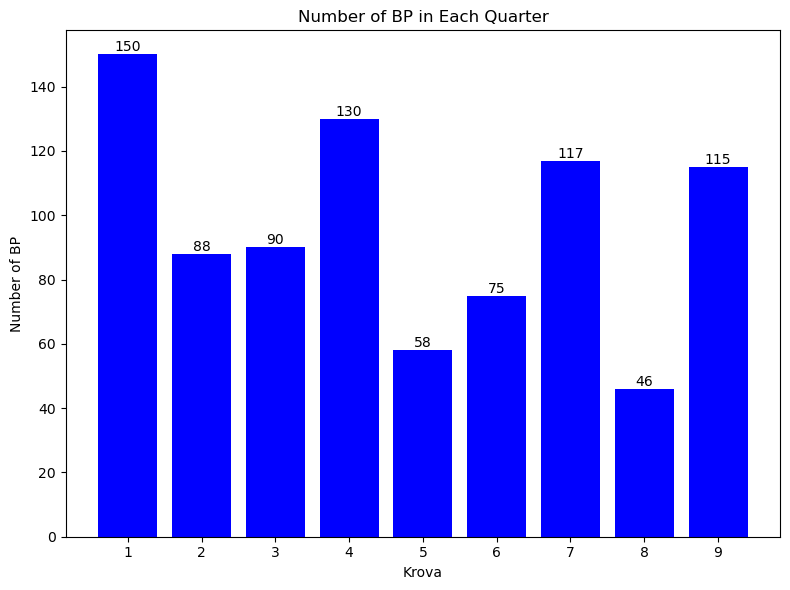

In [77]:
# Grouping by 'krova' and counting occurrences
bp_count_in_q = bp_in_q['krova'].value_counts().reset_index()
bp_count_in_q.columns = ['krova', 'count']
plot_bar_chart(bp_count_in_q['krova'], bp_count_in_q['count'], 'Number of BP in Each Quarter', 'Krova', 'Number of BP')

#### Which Quarter has more BP in total length

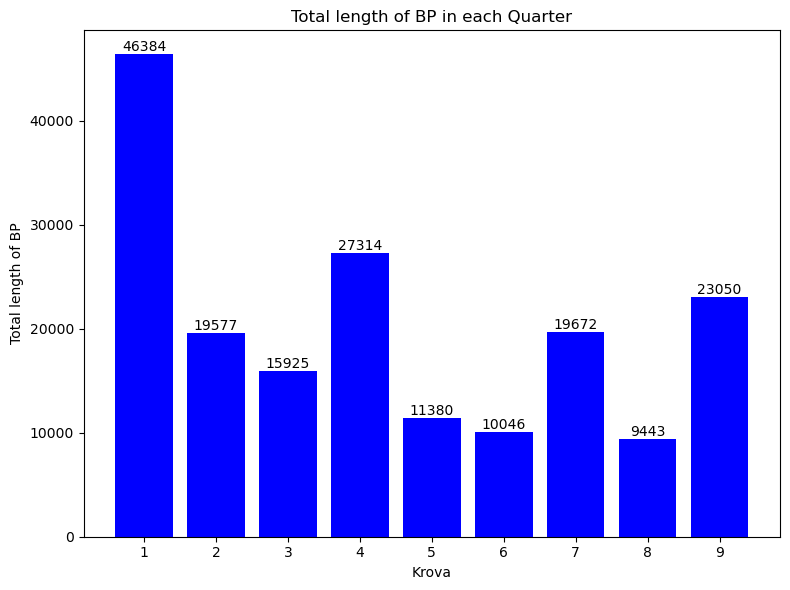

In [78]:
bp_sum_df = pd.DataFrame(bp_in_q.groupby('krova').bp_length.sum())
bp_sum_df.bp_length = bp_sum_df.bp_length.astype('int32')

plot_bar_chart(bp_sum_df.index, bp_sum_df['bp_length'], 'Total length of BP in each Quarter', 'Krova', 'Total length of BP')


Conclusions:

Quarter 1 has the highest number of individual BP and the most BP length by more than twice the second place.<br>
Quarter 4 and 9 are second and third respectively.

I would expect to see Quarter 1 to have the least amount of accidents of all the quarters.

---

#### Plotting number of Micro Mobility accidents in each Quarter

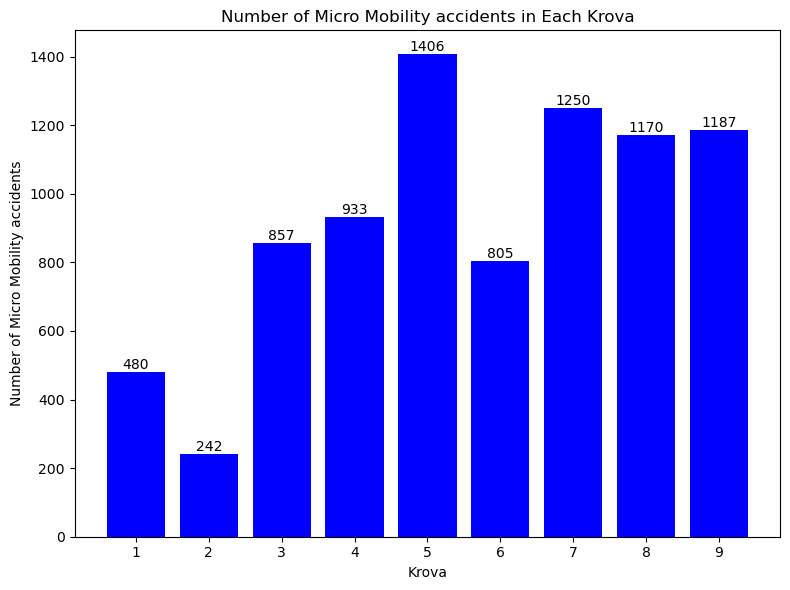

In [79]:
mm_accidents_count_krova = pd.DataFrame(i_m_h_ta_mm_quarters_gdf.groupby('krova').provider_and_id.nunique()).reset_index()
plot_bar_chart(mm_accidents_count_krova['krova'], mm_accidents_count_krova['provider_and_id'], 'Number of Micro Mobility accidents in Each Krova', 'Krova', 'Number of Micro Mobility accidents')

# mm_accidents_count_krova = i_m_h_ta_mm_quarters_gdf['krova'].value_counts().reset_index()
# plot_bar_chart(mm_accidents_count_krova['krova'], mm_accidents_count_krova['count'], 'Number of Micro Mobility accidents in Each Krova', 'Krova', 'Number of Micro Mobility accidents')

Conclusions:

We see that Quarter 1 does not have the lowest number of accidents, it is the second place.<br>
Quarter 2 has the lowest by a large margine

The quarter with the highest number of MM accidents is 5.

---

#### Plotting number of accidents that are not Micro Mobility in each quarter

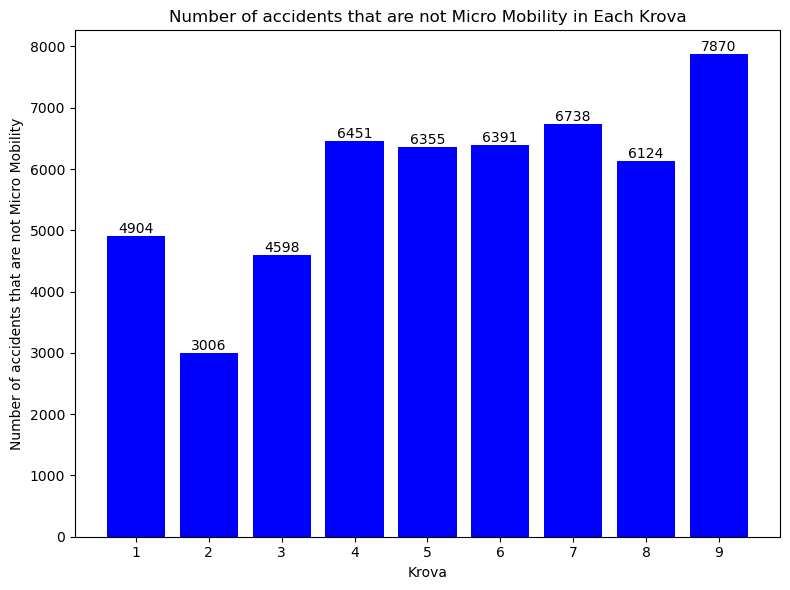

In [80]:
no_mm_accidents_count_krova = pd.DataFrame(i_m_h_ta_no_mm_quarters_gdf.groupby('krova').provider_and_id.nunique()).reset_index()
plot_bar_chart(no_mm_accidents_count_krova['krova'], no_mm_accidents_count_krova['provider_and_id'], 'Number of accidents that are not Micro Mobility in Each Krova', 'Krova', 'Number of accidents that are not Micro Mobility')

# no_mm_accidents_count_krova = i_m_h_ta_no_mm_quarters_gdf['krova'].value_counts().reset_index()
# plot_bar_chart(no_mm_accidents_count_krova['krova'], no_mm_accidents_count_krova['counts'], 'Number of accidents that are not Micro Mobility in Each Krova', 'Krova', 'Number of accidents that are not Micro Mobility')



Conclusion:

Quarter 9 has the highest number of accidents that are not micro mobility

Quarter 1 has the 4th lowest.

The lowest is Quarter 2 by a large difference to the second place Q 3 by around 30%.

---

#### Plotting number of streets in each Quarter

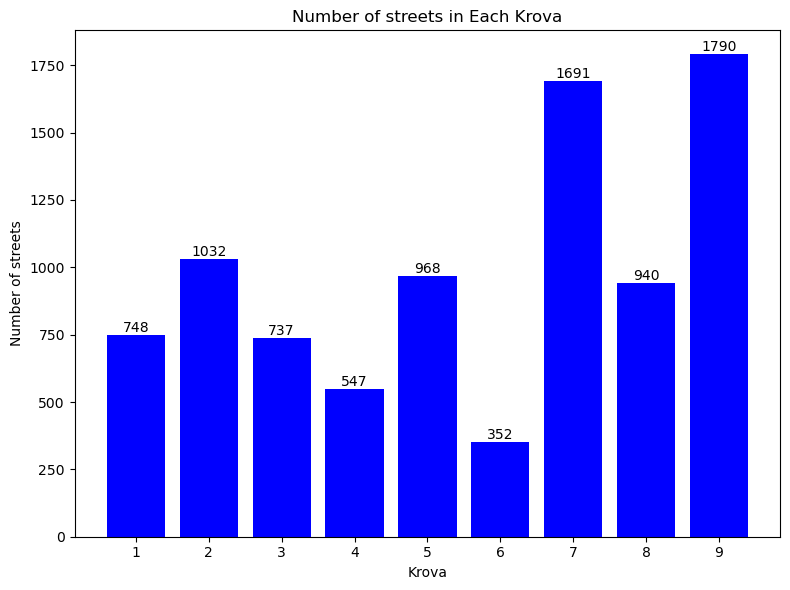

In [81]:
streets_in_krova = streets_in_q['krova'].value_counts().reset_index()
plot_bar_chart(streets_in_krova['krova'], streets_in_krova['count'], 'Number of streets in Each Krova', 'Krova', 'Number of streets')

#### Plotting total length of streets in each Quarter

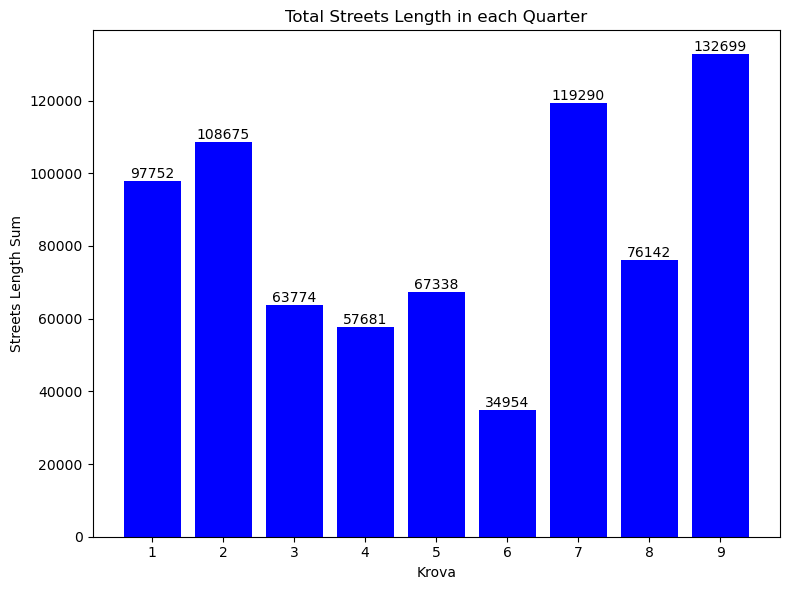

In [82]:
streets_length_sum_df = pd.DataFrame(streets_in_q.groupby('krova').street_length.sum())
streets_length_sum_df.street_length = streets_length_sum_df.street_length.astype('int32')
plot_bar_chart(streets_length_sum_df.index, streets_length_sum_df['street_length'], 'Total Streets Length in each Quarter', 'Krova', 'Streets Length Sum')

#### Plotting total streets length in relation to quarter area

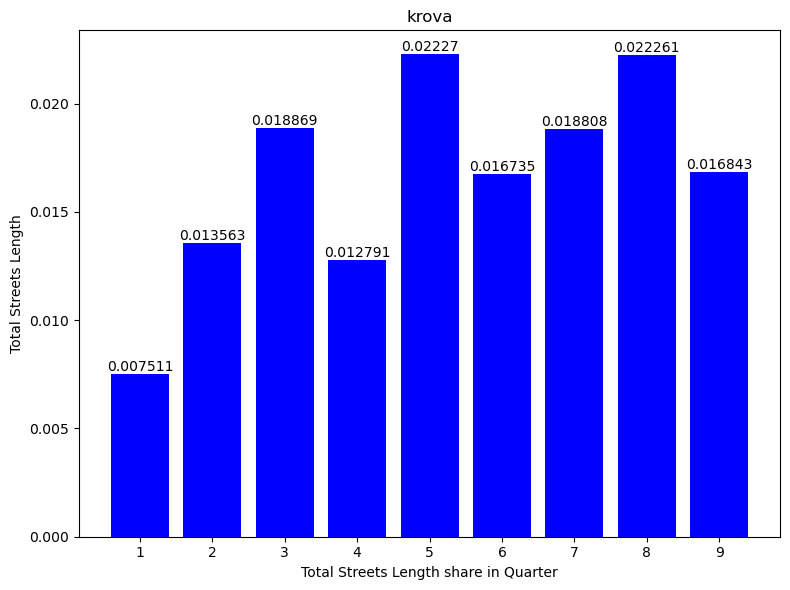

In [83]:
krova_values = streets_in_krova.sort_values(by='krova')['krova'].values
street_total_length_krova_area_ratio_ls = (streets_length_sum_df['street_length'].to_list()/ ta_q.sort_values(by='krova').area).to_list()
total_length_streets_krova_share = pd.DataFrame(street_total_length_krova_area_ratio_ls,columns=['street_ln_share_in_q'], index=krova_values)

plot_bar_chart(total_length_streets_krova_share.index, total_length_streets_krova_share['street_ln_share_in_q'], 'krova', 'Total Streets Length share in Quarter','Total Streets Length',6 )

#### Plotting number of BP in relation to Quarter area

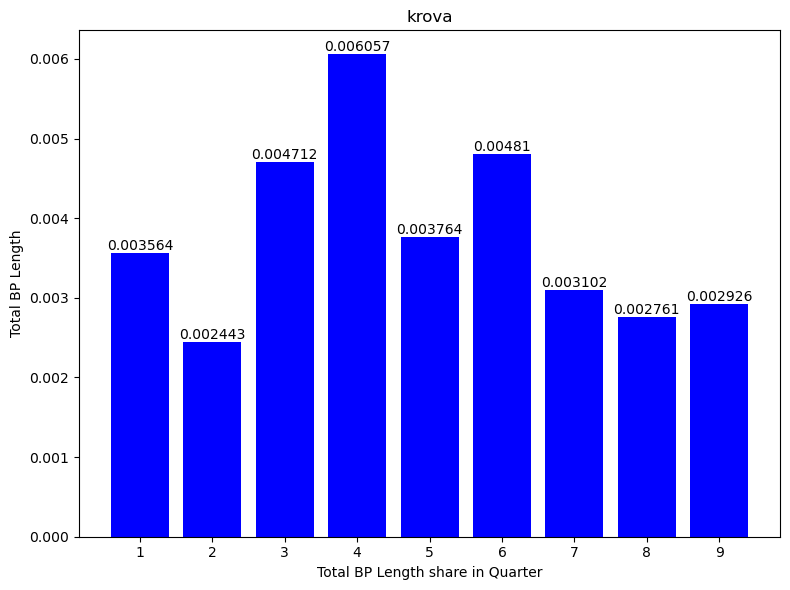

In [84]:
krova_values = streets_in_krova.sort_values(by='krova')['krova'].values
bp_total_length_krova_area_ratio_ls = (bp_sum_df['bp_length'].to_list()/ ta_q.sort_values(by='krova').area).to_list()
bp_total_length_krova_area_ratio_ls
bp_total_length_krova_share = pd.DataFrame(bp_total_length_krova_area_ratio_ls,columns=['bp_ln_share_in_q'], index=krova_values)

plot_bar_chart(bp_total_length_krova_share.index, bp_total_length_krova_share['bp_ln_share_in_q'], 'krova', 'Total BP Length share in Quarter','Total BP Length',6 )

#### Plotting Number of BP in relation to number of streets in each quarter

#### Plotting BP total length in relation to Streets total length in each quarter

In [85]:
mm_accident_share = pd.DataFrame((mm_accidents_count_krova['provider_and_id']/mm_accidents_count_krova['provider_and_id'].sum()))
mm_accident_share.columns = ['mm_accident_share']
mm_accident_share

,mm_accident_share
0,0.057623
1,0.029052
2,0.102881
3,0.112005
4,0.168788
5,0.096639
6,0.150060
7,0.140456
8,0.142497


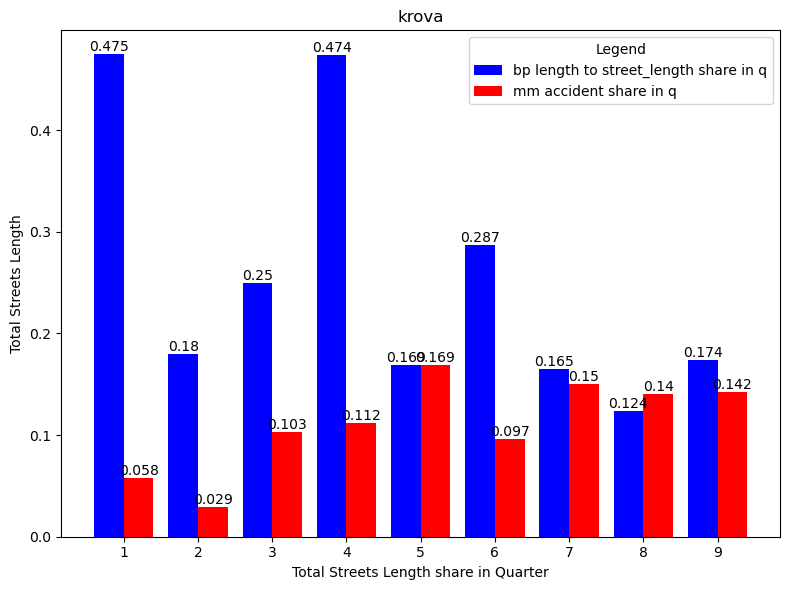

In [86]:
krova_values = bp_in_q.sort_values(by='krova')['krova'].unique()
bp_total_length_street_length_in_q_ratio_ls = (bp_sum_df['bp_length']/streets_length_sum_df['street_length']).to_list()
bp_length_to_street_length_share = pd.DataFrame(bp_total_length_street_length_in_q_ratio_ls,columns=['bp_ln_ratio_street_ln'], index=krova_values)

plot_bar_chart_2(krova_values, bp_length_to_street_length_share['bp_ln_ratio_street_ln'],mm_accident_share['mm_accident_share'], 'krova', 'Total Streets Length share in Quarter','Total Streets Length', 'bp length to street_length share in q','mm accident share in q',3 )

#### Plotting avg street width in each quarter

#### Plotting accidents severity for MM and no MM in each quarter.

#### Plotting number of accidents per quarter through the years.

#### **Compare Quarter Area:**

In [87]:
max_accidents_in_all_krova_and_year  = i_m_h_ta_quarters_gdf.groupby(['krova', 'accident_year']).provider_and_id.nunique()
# max_accidents_in_all_krova_and_year  = i_m_h_ta_quarters_gdf.groupby(['krova','accident_year']).count().max()
max_accidents_in_all_krova_and_year

krova  accident_year
1      2013             608
       2014             510
       2015             571
       2016             505
       2017             505
                       ... 
9      2020             543
       2021             562
       2022             570
       2023             542
       2024             207
Name: provider_and_id, Length: 108, dtype: int64

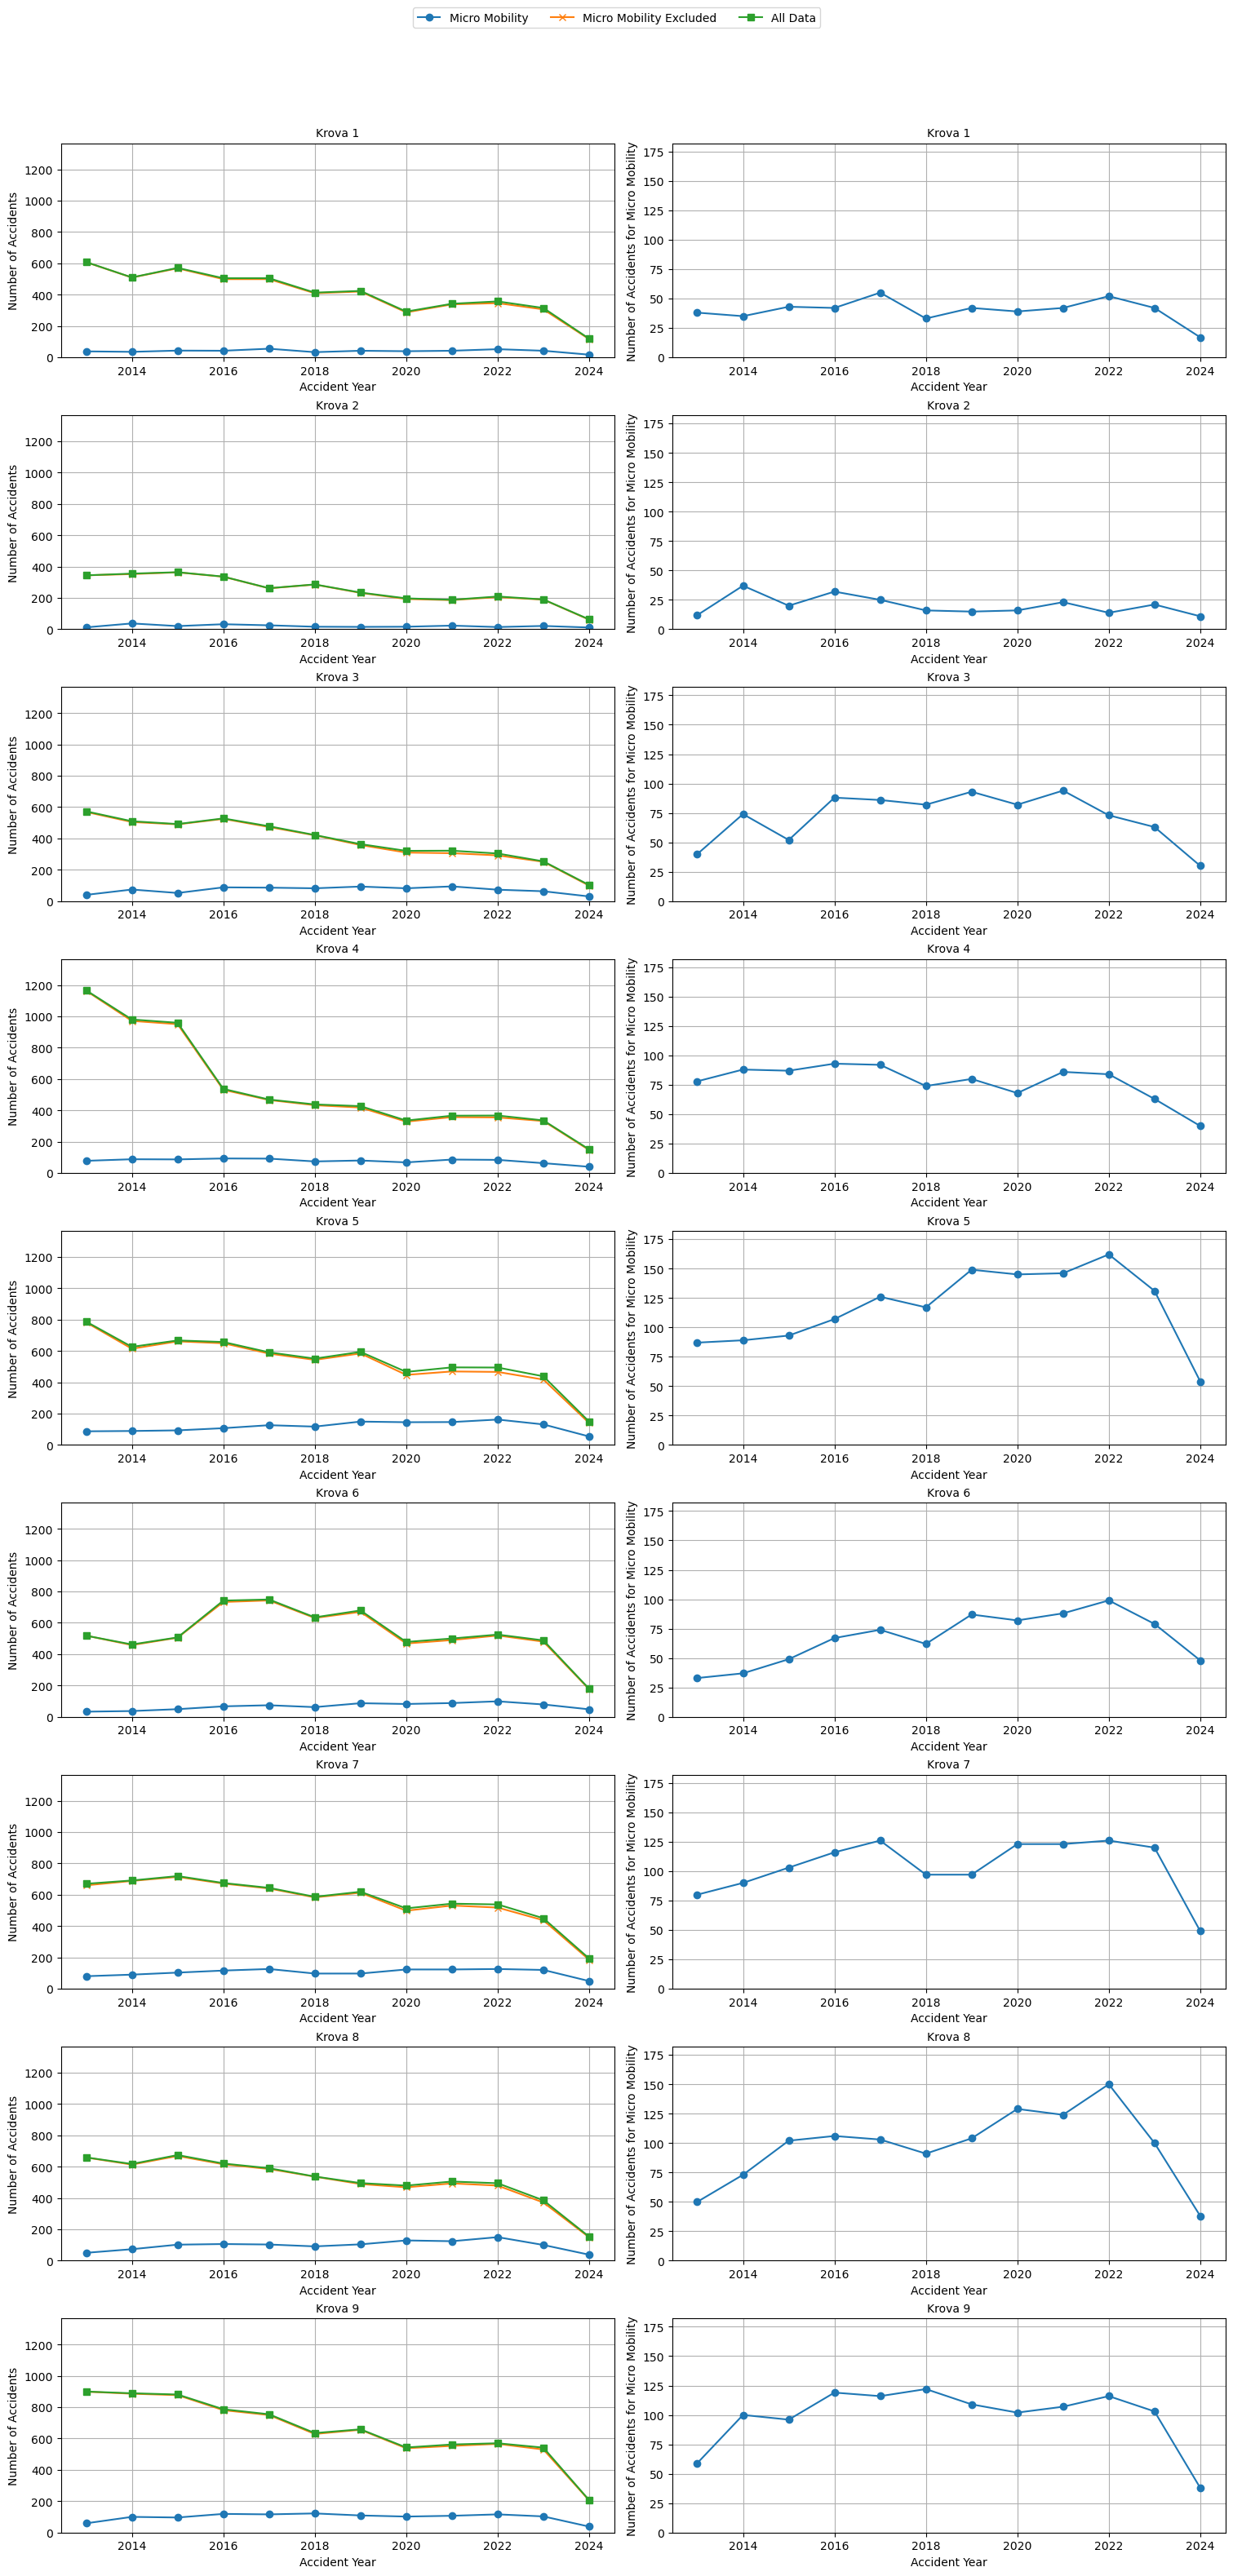

In [88]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

# Group data
i_m_h_ta_q_gb_krova = i_m_h_ta_quarters_gdf.groupby(['krova', 'accident_year']).provider_and_id.nunique().reset_index(name='counts')
# i_m_h_ta_q_gb_krova = i_m_h_ta_quarters_gdf.groupby(['krova', 'accident_year'])..size().reset_index(name='counts')
i_m_h_ta_no_mm_q_gb_krova = i_m_h_ta_no_mm_quarters_gdf.groupby(['krova', 'accident_year']).provider_and_id.nunique().reset_index(name='counts')
# i_m_h_ta_no_mm_q_gb_krova = i_m_h_ta_no_mm_quarters_gdf.groupby(['krova', 'accident_year']).size().reset_index(name='counts')
i_m_h_ta_mm_q_gb_krova = i_m_h_ta_mm_quarters_gdf.groupby(['krova', 'accident_year']).provider_and_id.nunique().reset_index(name='counts')
# i_m_h_ta_mm_q_gb_krova = i_m_h_ta_mm_quarters_gdf.groupby(['krova', 'accident_year']).size().reset_index(name='counts')

max_accidents_in_all_krova_and_year  = i_m_h_ta_quarters_gdf.groupby(['krova', 'accident_year']).provider_and_id.nunique().max()
# max_accidents_in_all_krova_and_year  = i_m_h_ta_quarters_gdf.groupby(['krova','accident_year']).count().max().values[0]
max_accidents_in_mm_krova_and_year  = i_m_h_ta_mm_quarters_gdf.groupby(['krova', 'accident_year']).provider_and_id.nunique().max()
# max_accidents_in_mm_krova_and_year   = i_m_h_ta_mm_quarters_gdf.groupby(['krova', 'accident_year']).count().max().values[0]

# Get unique krovas
krovas = i_m_h_ta_mm_q_gb_krova['krova'].unique()

# Determine the number of plots needed
num_plots = len(krovas) * 2
num_rows = 9
num_cols = 2

# Create subplots with adjusted margins
fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 30), constrained_layout=True)
axes = axes.flatten()

# Plot each krova
for idx, krova in enumerate(krovas):
    if idx < num_plots:
        # ax for plotting all lines
        ax_all = axes[idx*2]

        # ax for plotting just micro mobility
        ax_mm = axes[idx*2 +1]
        
        # Plot line for i_m_h_ta_mm_q_gb_krova
        subset_mm = i_m_h_ta_mm_q_gb_krova[i_m_h_ta_mm_q_gb_krova['krova'] == krova]
        ax_all.plot(subset_mm['accident_year'], subset_mm['counts'], marker='o', label='Micro Mobility')
        
        # Plot line for i_m_h_ta_no_mm_q_gb_krova
        subset_no_mm = i_m_h_ta_no_mm_q_gb_krova[i_m_h_ta_no_mm_q_gb_krova['krova'] == krova]
        ax_all.plot(subset_no_mm['accident_year'], subset_no_mm['counts'], marker='x', label='Micro Mobility Excluded')
        
        # Plot line for i_m_h_ta_gdf
        subset_all = i_m_h_ta_q_gb_krova[i_m_h_ta_q_gb_krova['krova'] == krova]
        ax_all.plot(subset_all['accident_year'], subset_all['counts'], marker='s', label='All Data')
        
        ax_all.set_title(f'Krova {krova}', fontsize=10)
        ax_all.set_xlabel('Accident Year')
        ax_all.set_ylabel('Number of Accidents')
        ax_all.set_ylim(0, max_accidents_in_all_krova_and_year + 200)
        ax_all.grid(True)
        ax_all.xaxis.set_major_locator(MaxNLocator(integer=True))

        ax_mm.plot(subset_mm['accident_year'], subset_mm['counts'], marker='o', label='Micro Mobility')
        ax_mm.set_title(f'Krova {krova}', fontsize=10)
        ax_mm.set_xlabel('Accident Year')
        ax_mm.set_ylabel('Number of Accidents for Micro Mobility')
        ax_mm.set_ylim(0, max_accidents_in_mm_krova_and_year + 20)
        ax_mm.grid(True)
        ax_mm.xaxis.set_major_locator(MaxNLocator(integer=True))
    else:
        fig.delaxes(axes[idx])

# Create a single legend outside of the subplots
handles, labels = ax_all.get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center', ncol=3, bbox_to_anchor=(0.5, 1.05))

plt.show()


### Plotting number of accidents in relation to BP length

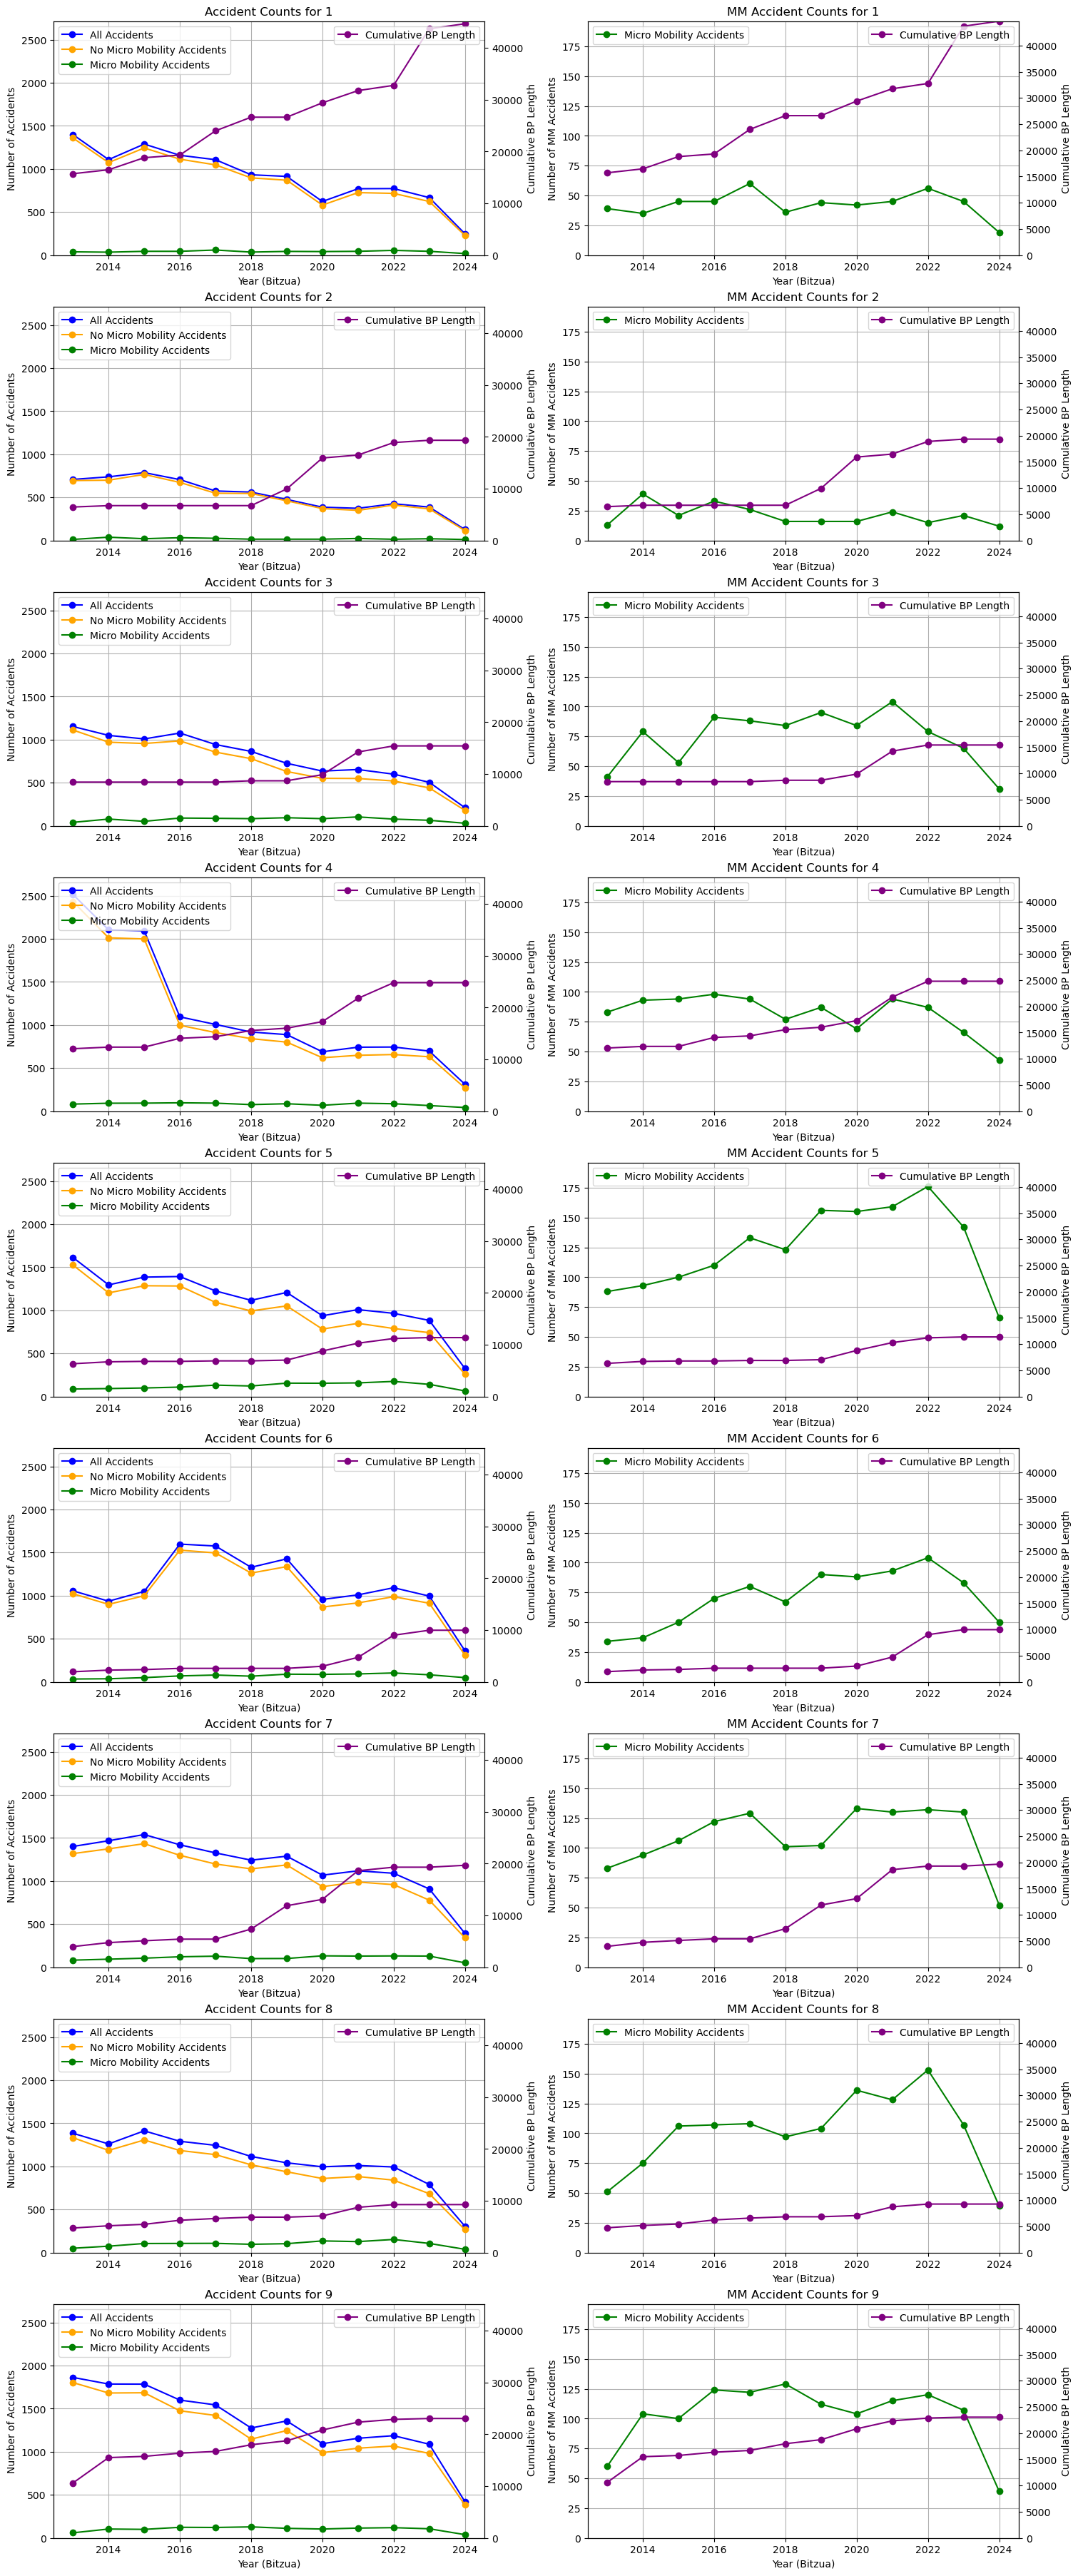

In [89]:
import matplotlib.pyplot as plt

# Calculate maximum values for y-axis limits
max_all_accidents = bp_krova_filtered['all_acc_cnt'].max()
max_mm_accidents = bp_krova_filtered['mm_acc_cnt'].max()
max_cum_bp_length = bp_krova_filtered['cum_bp_length'].max()

# Prepare the figure with 9 rows and 2 columns
fig, axs = plt.subplots(9, 2, figsize=(15, 36), constrained_layout=True)

# Flatten the 2D grid of axs for easy iteration
axs = axs.flatten()

# Colors for different types of accidents
colors = ['blue', 'orange', 'green']
labels = ['All Accidents', 'No Micro Mobility Accidents', 'Micro Mobility Accidents']

# Iterate over each unique city quarter
for i, quarter in enumerate(bp_krova_filtered.index.get_level_values('krova').unique()):
    if i < len(axs) // 2:  # Ensure we don't exceed the number of available subplots
        # Extract data for this city quarter
        data = bp_krova_filtered.loc[quarter]
        
        # First plot in the row
        ax1 = axs[2 * i]
        ax1.plot(data.index.get_level_values('bitzua'), data['all_acc_cnt'], 'o-', color=colors[0], label=labels[0])
        ax1.plot(data.index.get_level_values('bitzua'), data['no_mm_acc_cnt'], 'o-', color=colors[1], label=labels[1])
        ax1.plot(data.index.get_level_values('bitzua'), data['mm_acc_cnt'], 'o-', color=colors[2], label=labels[2])
        ax1.set_title(f'Accident Counts for {quarter}')
        ax1.set_xlabel('Year (Bitzua)')
        ax1.set_ylabel('Number of Accidents')
        ax1.set_ylim(0, max_all_accidents + 200)
        ax1.legend(loc='upper left')
        ax1.grid(True)
        # Create a secondary y-axis for cum_bp_length
        ax1_right = ax1.twinx()
        ax1_right.plot(data.index.get_level_values('bitzua'), data['cum_bp_length'], 'o-', color='purple', label='Cumulative BP Length')
        ax1_right.set_ylabel('Cumulative BP Length')
        ax1_right.set_ylim(0, max_cum_bp_length + 500)
        ax1_right.legend(loc='upper right')
        
        # Second plot in the row
        ax2 = axs[2 * i + 1]
        ax2.plot(data.index.get_level_values('bitzua'), data['mm_acc_cnt'], 'o-', color=colors[2], label=labels[2])
        ax2.set_title(f'MM Accident Counts for {quarter}')
        ax2.set_xlabel('Year (Bitzua)')
        ax2.set_ylabel('Number of MM Accidents')
        ax2.set_ylim(0, max_mm_accidents + 20)
        ax2.legend(loc='upper left')
        ax2.grid(True)

        # Create a secondary y-axis for cum_bp_length
        ax2_right = ax2.twinx()
        ax2_right.plot(data.index.get_level_values('bitzua'), data['cum_bp_length'], 'o-', color='purple', label='Cumulative BP Length')
        ax2_right.set_ylabel('Cumulative BP Length')
        ax2_right.set_ylim(0, max_cum_bp_length)
        ax2_right.legend(loc='upper right')

# Hide any unused subplots
for j in range(2 * i + 2, len(axs)):
    fig.delaxes(axs[j])

# Display the plot
plt.show()
